In [1]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob
import string

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy import integrate

import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import ticker
from matplotlib.legend import Legend

from utils import *
from plot_utils import *
from AnalyseDefects_dev import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll
from AnalyseDefectsMinimal import AnalyseDefectsMinimal

plt.style.use('sg_article')
plt.rcParams.update({"text.usetex": True})

In [3]:
system_size_list = [256, 512,1024, 2048]
#system_size_list = [2048]
ada = AnalyseDefectsAll(system_size_list)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_2552\3030341680.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(act_list,corr_time_av[1 if tau_simple else 0,:,0], yerr=corr_time_av[1 if tau_simple else 0,:,1],


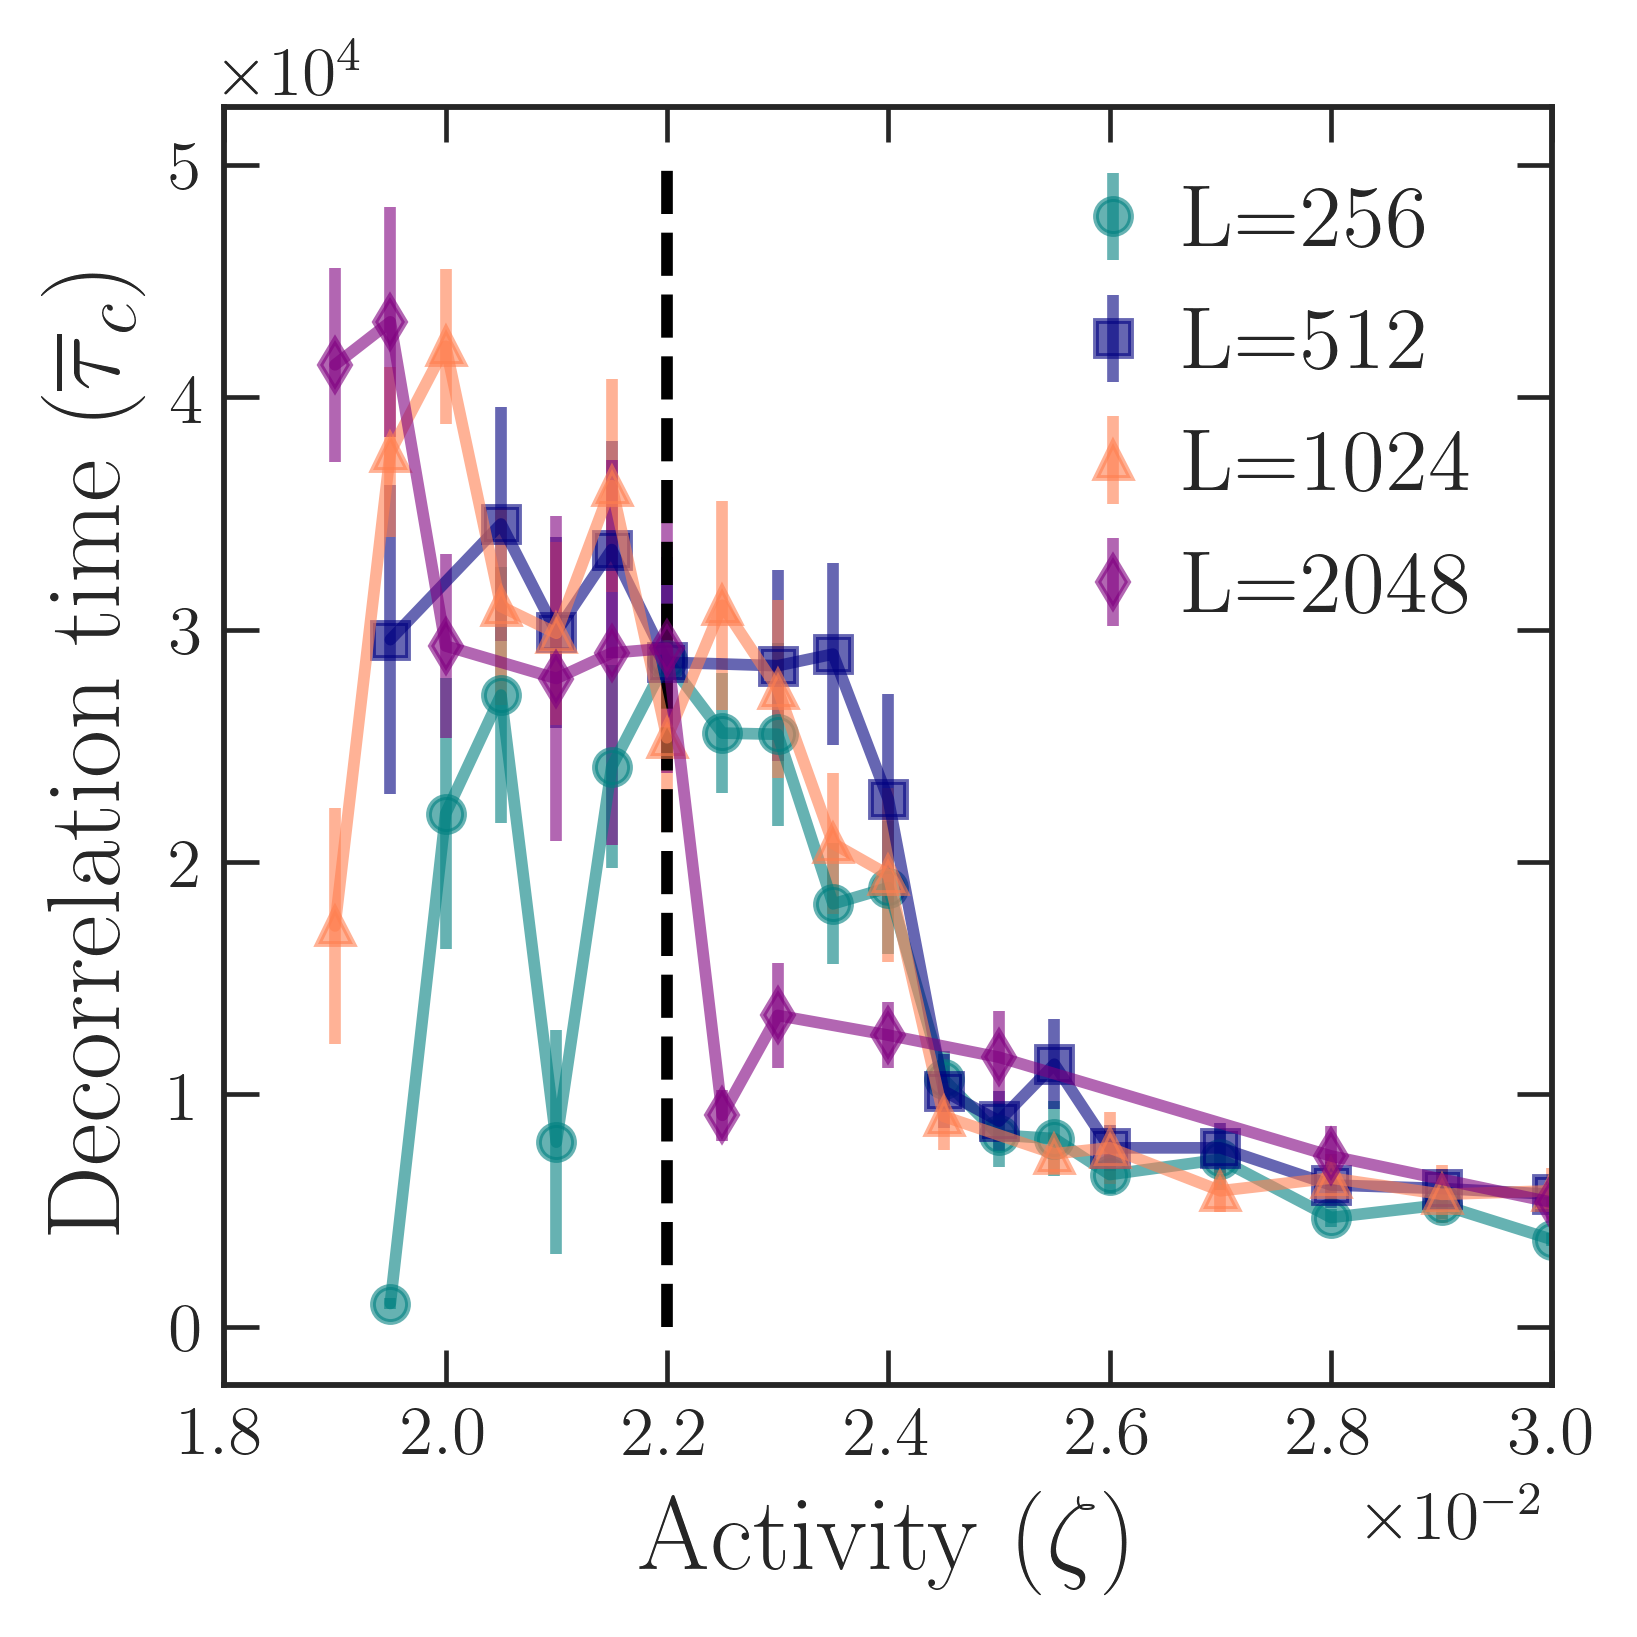

In [28]:
ninfo = 500
tau_simple = True
fig, ax = plt.subplots(ncols=1,nrows=1, figsize = (4,4))
color = ['r','g','b', 'k']
marker = ['o','s','^','d']

#act_sigma = [0.0205, 0.021,0.0215,0.022]#, 0.023]
#sigma_arr = np.zeros([4,len(act_sigma),2])

L_list = [256,512,1024,2048]
act_min_idx_list = [0,0,0,0]# [2, 2, 2]

for j, LL in enumerate(L_list):

    output_path = f'data\\na{LL}'
    mode = 'all' # 'all' or 'short'

    defect_list = gen_analysis_dict(LL, mode)

    ad = AnalyseDefects(defect_list, output_path=output_path)

    out_path_merged = ad.output_main_path + '\\merged_results'

    #order_param_av = np.load(out_path_merged + '\\order_param_av.npy')
    act_list = np.load(out_path_merged + '\\activity_list.npy')[act_min_idx_list[j]:]   
    corr_time_av = np.load(out_path_merged + '\\def_corr_time_av.npy')[:,act_min_idx_list[j]:,:]

    corr_time_av *= ninfo
    if LL == 1024:
        act_idx = np.where(act_list == 0.022)[0][0]
      #  corr_time_av[:,act_idx,:] *= 8
       # corr_time_av[:,-1,:] *=8

    ax.errorbar(act_list,corr_time_av[1 if tau_simple else 0,:,0], yerr=corr_time_av[1 if tau_simple else 0,:,1], 
                label=f'L={LL}', fmt='o-', marker=marker[j], alpha=.6)

ax.vlines(0.022, 0, 50000, linestyles='dashed', colors='k')
ax.legend();
ax.set_xlim([0.018,0.03])
ax.set_xlabel(r'Activity ($\zeta$)')
ax.set_ylabel(r'Decorrelation time ($\overline{\tau}_c$)')
fig.tight_layout()

In [4]:
def gen_analysis_dict_minimal(LL, mode,):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LL}sd', \
              suffix = "short", priority = -1, LX = LL, Nframes = 200, Ninfo = 2000)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LL}sd_l', \
                suffix = "l", priority = 0, LX = LL, Nframes = 200, Ninfo = 5000)
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LL}sd_vl',\
                    suffix = "vl", priority = 3, LX = LL, Nframes = 500, Ninfo = 10000)

    defect_list = [dshort, dlong, dvery_long,] if mode == 'all' else [dshort]
    return defect_list

LL = 512
output_path = f'data\\na512sd'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict_minimal(LL, mode)

 
adm = AnalyseDefectsMinimal(defect_list, output_path=output_path)

extract = False
analyze = False

In [5]:
def plot_sus(ax):

    marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

    act_max = 0.022
    normalize_sus = False

    xmin = 0.37
    ymin = 0.08
    width = 0.35

    inset_box = [0.4, 0.23,width,2*width]
    axinn = ax.inset_axes(inset_box)

    axinn_xlims = [0.0175, 0.0265]
    axinn_ylims = [-.25, 11.49]
    axinn_xticks = [1.8e-2, 2.2e-2,2.6e-2]
    ax1_xlims = [0.013, 0.08005]
    axinn_yticks = np.round(np.linspace(2, 10, 5)).astype('int')
    axinn.set(xticks=axinn_xticks, yticks=axinn_yticks, xticklabels=axinn_xticks, yticklabels=axinn_yticks, xlim=axinn_xlims, ylim=axinn_ylims)
    ax.indicate_inset_zoom(axinn) 
    axinn.tick_params(axis='both',which='major', labelsize=11.5)

    xticks = np.round(np.linspace(0.02, 0.1, 5), 2)

    ax.set(xticks=xticks,xticklabels=xticks, xlim=ax1_xlims,)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))    
    

    for N, act_list in enumerate(ada.act_list):

        sus = ada.get_susceptibility(ada.LX[N])
        act_max_idx = act_list.index(act_max)

        if normalize_sus:    
            sus = sus / sus[act_max_idx].max()

        label = f'L = {ada.LX[N]}'
        ax.errorbar(act_list, sus[:,0],sus[:,1],
                    fmt=f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, elinewidth=1.5, label=label)
        axinn.errorbar(act_list, sus[:,0],sus[:,1], fmt=f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4,elinewidth=1.5)

    #ax.set_xlabel(r'Activity ($\zeta$)')
    ax.set_ylabel(r'Active susceptibility ($\overline{\chi_a})$')
    axinn.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw=1, alpha=.7, linestyle = '--')
    ax.vlines(act_max, 0, 2 * axinn_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    #ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))

    #xticks = np.round(np.linspace(0.02, 0.1, 5), 2)
    axinn.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    axinn.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))

    #axinn.legend()
    #ax.legend()


    ax.hlines(0, 0, 0.1, color = 'k', linestyle='-', lw = 1.5)
    #ax.set(xlabel = r'Activity ($\zeta$)')
    #fig.supxlabel(r'Activity ($\zeta$)',x=0.52, y=0.04)
    #fig.legend(ncol=8, fontsize = 16, bbox_to_anchor=(0.88, 1.08))

    #fig.savefig('data/nematic_analysis_all/susceptibility.eps', dpi = 720, pad_inches = .5)
        
    return ax

def plot_defects_per_activity(obj, activity, ax = None, marker='.', markersize=6, Ndataset = 0, stationarity_dict = {}, alpha = 0.55):
        
  output_path = obj.output_paths[Ndataset]

  act_idx = list(obj.act_list[Ndataset]).index(activity)   
  Nframes = obj.Nframes[Ndataset]

  try:
      defect_arr_av = obj.get_arrays_av(Ndataset = Ndataset)[0] 
  except:
      print('Defect array not found. Analyse defects first.')
      return

  return_fig = False
  if ax is None:
      fig, ax = plt.subplots(figsize=(12, 6))
      return_fig = True


  ax.errorbar(np.arange(0, Nframes * obj.Ninfo[Ndataset], obj.Ninfo[Ndataset]), \
                      defect_arr_av[:, act_idx, 0], defect_arr_av[:, act_idx, 1], fmt=marker, \
                      alpha = alpha, markersize=markersize, color = f'C{1}', label = rf'$\zeta = {activity}$') 

  if stationarity_dict != {}:
          x = est_stationarity(defect_arr_av[:, act_idx, 0], **stationarity_dict)[0]
  else:
      x = obj.conv_list[Ndataset][act_idx]
      
  if x > 0:
      ax.vlines(x, ymin=0,\
                ymax=defect_arr_av[int(x/obj.Ninfo[Ndataset]), act_idx, 0], 
               color='black', linestyle='--', alpha=0.5)
  ax.grid()
  ax.set(ylim = (0, np.max(defect_arr_av[:, act_idx, 0]) * 1.5))

  if return_fig:
      return fig, ax
  return ax

def plot_slowdown(ax):

  axes = [ax['F'], ax['A']]
  scale_with_activity = True
  act_idx_cutoff_512 = 2

  X_256 = np.array([0.02, 0.0225, 0.023, 0.0235, 0.032])
  Y_256 = np.array([2.5e6, (1.5e6 + 2.75e6) / 2, 5e5, 2.9e5, 2.5e4])
  dY_256 = np.array([1e5, np.std([1.5e6, 2.75e6]), 1e5, 5e4, 2e4])

  X_1024 = np.array([0.02, 0.0205, 0.021, 0.022, .0225, 0.023, 0.024, 0.0245, 0.026, 0.03])
  Y_1024 = np.array([2.5e6, 2.5e6, 2.5e6, 2.5e6, 1.25e6, (6e5+6.5e5)/2, (3e5+4e5)/2, (3.5e5+4.2e5)/2,(2e5+3e5)/2, 2.5e4])
  dY_1024 = np.array([2e5, 2e5, 2e5, 2e5, 1e5, np.std([6e5, 6.5e5]), np.std((3e5+4e5)/2), np.std([3.5e5, 4.2e5]), np.std([2e5, 3e5]), 2e4])


  act_list_full = []
  for act_list in adm.act_list:
      act_list_full.extend(act_list)
  act_list_full.sort()

  act_list_full = act_list_full[act_idx_cutoff_512:]
  conv_list = np.array([*adm.conv_list[2], *adm.conv_list[1], *adm.conv_list[0]])[act_idx_cutoff_512:]
  conv_list_err = np.array([*adm.conv_list_err[2], *adm.conv_list_err[1], *adm.conv_list_err[0]]  )[act_idx_cutoff_512:]

  act_p = 1
  scaling = 1
  conv_list_active = scaling * np.array(act_list_full)**act_p * conv_list
  conv_list_active_err = np.array(act_list_full)**act_p * conv_list_err

  #fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))
  marker_list = ['s', 'o', '^', 'v']

  for marker, LX, X, Y, dY in zip(marker_list, [256, 512, 1024], [X_256, act_list_full, X_1024],\
                                  [Y_256, conv_list, Y_1024], [dY_256, conv_list_err, dY_1024]):
      if scale_with_activity:
          Y = np.array(Y) * np.array(X)**act_p
          dY = np.array(dY) * np.array(X)**act_p
      axes[0].errorbar(X, Y, yerr=dY, lw=1.5, fmt = f'{marker}-', capsize=2, markersize=4, alpha=.7)# ecolor='teal', elinewidth=1,\

  act_crit_idx = act_list_full.index(0.022)
  scaling = 0.0005
  Y = conv_list[act_crit_idx] * np.exp(- (act_list_full[act_crit_idx:] - act_list_full[act_crit_idx]) / scaling)

  axes[0].set(xlabel=rf'Activity ($\zeta$)',)# ylabel=r'$\tau_{SS} \cdot \zeta$',)
  #ax[0].legend()
  #ax.set_yscale('log')
  #ax.grid(True, which = 'both')
  xticks0 = [0.02, 0.022, 0.024, 0.026, 0.028, 0.030]
  axes[0].set(xticks=xticks0, xticklabels=xticks0)
  axes[0].set(xlim=(0.01925, 0.03025),ylim=(0,8e4))
  axes[0].xaxis.set_minor_locator(MultipleLocator(5e-4))
  axes[0].yaxis.set_minor_locator(MultipleLocator(1e4))
  #axes[0].tick_params(axis='both',which='major', labelsize=10)
  axes[0].set_ylabel(ylabel=r'Relaxation time ($\hat{\tau}_{ss} / \tau_a$)',)# fontsize=16)



  act_list = [0.022, 0.026, 0.034]
  #axes[1].set_xlim(0,3)
  #axes[2].set(xlim = (0,1.9e5))#, xticks = np.linspace(0,5e5,5))#, xticklabels = np.linspace(0,5e5,5))
  #axes[3].set(xlim = (0,8e4))#, xticks = np.linspace(0,5e5,5))#, xticklabels = np.linspace(0,5e5,5))
  plot_defects_per_activity(adm, activity=act_list[0], ax = ax['A'], Ndataset=2, alpha=.25, marker='s')
  plot_defects_per_activity(adm, activity=act_list[1], ax = ax['A'], Ndataset=1, alpha=.25, marker='o')
  plot_defects_per_activity(adm, activity=act_list[2], ax = ax['A'], Ndataset=0, alpha=.25, marker='^')
  axes[1].set_ylabel(ylabel = r'Defect count ($\overline{N}$)')#,fontsize=16)
  axes[1].set_xlabel(xlabel = r'Time step', y=1) #($10^5$)', y=1)# fontsize=14, y=-1)
  xtick_list = [5e5, 2e4, 1e4]
  ytick_list = [50, 100, 250]
  xticks = [np.linspace(0,4e6,3), np.linspace(0.5e5,1.5e5,3), np.linspace(2e4,6e4,3)]
  xticklabels = [[0, 20, 40], [0.5, 1, 1.5], [0.2, 0.4, 0.6]]
  ax['A'].legend(fontsize=12)
  for i, ax in enumerate([axes[1]]):
    # ax.set(xlabel = 'Time step', ylabel = 'Defect count')
    #  ax.grid()
      xpos = 0.05 if i<2 else 0.5
      ax.set_xticks(xticks[i], xticklabels[i]) 
    #  ax.text(xpos, 0.95, rf'$\zeta = {act_list[i]}$', transform=ax.transAxes, fontsize=10, verticalalignment='top', fontweight='normal')
    #  ax.text(rf'$\zeta = {act_list[i]}$', x=0.5, y=0.9, transform=ax.transAxes, fontsize=12)    
      ax.xaxis.set_minor_locator(MultipleLocator(xtick_list[i]))
      ax.yaxis.set_minor_locator(MultipleLocator(ytick_list[i]))
      #ax.tick_params(axis='both',which='major', labelsize=10)


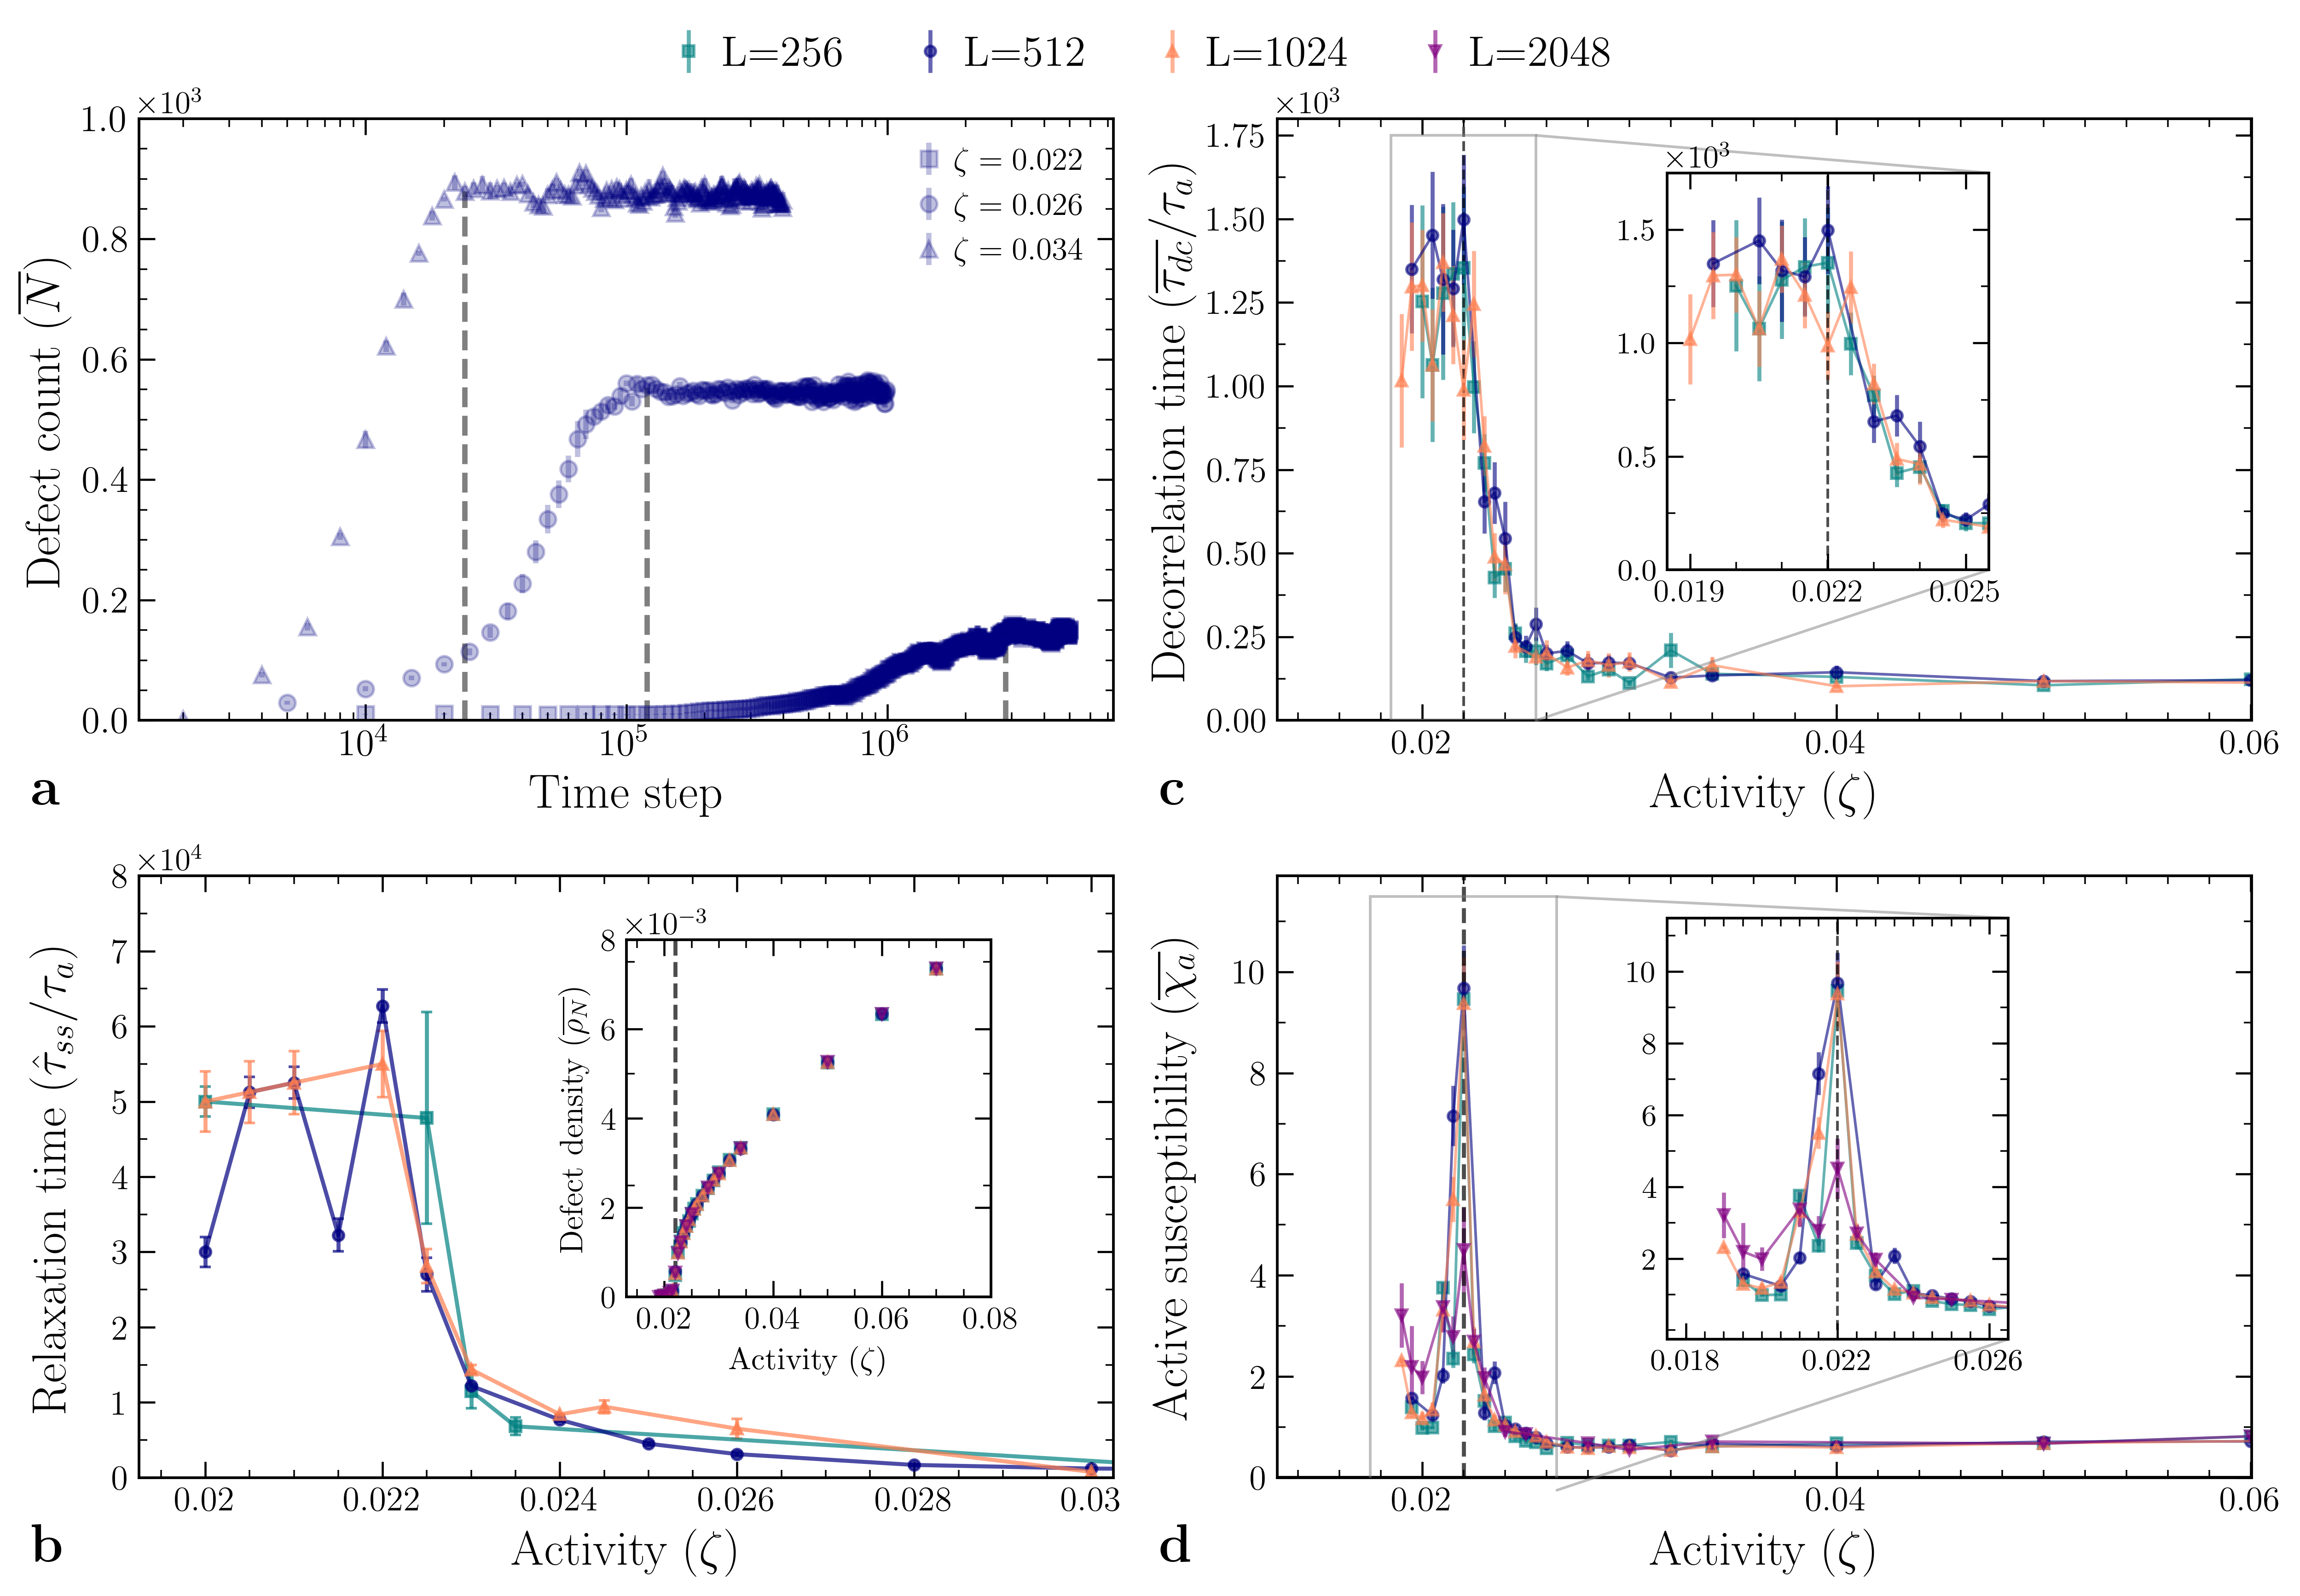

In [6]:

ninfo = 500
normalize_by_active_time=True
tau_simple = True
color = ['r','g','b', 'k']
marker = ['o','s','^','d']
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

#fig, ax0 = plt.subplot_mosaic("AAABB", figsize=(12,4))
fig, ax0 = plt.subplot_mosaic("AADD;FFGG", figsize=(12,8), height_ratios=[.5,.5],empty_sentinel=None)

ax_all = [ax0['A'], ax0['D'], ax0['F'], ax0['G']]
axes = [ax0['F'],ax0['D']]
#axes = [ax0['A'], ax0['B']]

#ax0 = ax0.flatten()
ax = axes[1]
axx = axes[0]
act_max = 0.022

xmin = 0.37
ymin = 0.08
width = 0.22

ms = 4

L_list = [256,512,1024,] #2048]
act_min_idx_list =[1,0,0,]# [1,0,1,] #2]

inset_box2 = [0.35, 0.34,width,2.5*width]
inset_box = [0.5, 0.3,1.7*width,2.7*width]
inset_box3 = [0.4, 0.25,1.5*width,3*width]
#axinn2 = axx.inset_axes(inset_box2)
axinn = axx.inset_axes(inset_box)
axinn3 = ax.inset_axes(inset_box3)

plot_slowdown(ax0)
axxs=ax0['A']
axxs.grid(False)
axxs.set_xscale('log')
axxs.set_ylim(ymax=1000);
#axx.set_xlabel
axxs.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)


##### SUS
axd = plot_sus(ax0['G'])  

labels = []
for j, LL in enumerate(L_list):

    output_path = f'data\\na{LL}'
    mode = 'all' # 'all' or 'short'

    defect_list = gen_analysis_dict(LL, mode)

    ad = AnalyseDefects(defect_list, output_path=output_path)

    out_path_merged = ad.output_main_path + '\\merged_results'

    act_list = np.load(out_path_merged + '\\activity_list.npy')[act_min_idx_list[j]:]   
    corr_time_av = np.load(out_path_merged + '\\def_corr_time_av.npy')[:,act_min_idx_list[j]:,:]

    corr_time_av *= ninfo
    if normalize_by_active_time:
        corr_time_av *= np.array(act_list)[None,:,None]
    if LL == 1024:
        act_idx = np.where(act_list == 0.022)[0][0]
       # corr_time_av[:,act_idx,:] *= 8
    
    ax.errorbar(act_list,corr_time_av[1 if tau_simple else 0,:,0], yerr=corr_time_av[1 if tau_simple else 0,:,1], 
                fmt=marker_shape[j], alpha=.6, ms=ms, lw=1, elinewidth=1.5, label=f'L={LL}')
    axinn3.errorbar(act_list,corr_time_av[1 if tau_simple else 0,:,0], yerr=corr_time_av[1 if tau_simple else 0,:,1],
                     fmt=marker_shape[j], alpha=.6, ms=ms, lw=1, elinewidth=1.5,)

ax.set_ylabel(r'Decorrelation time ($\overline{\tau_{dc}}$)' if not normalize_by_active_time else r'Decorrelation time ($\overline{\tau_{dc}} / \tau_a$)')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
axinn3.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)


axinn2_xlims = [0.0175, 0.0265]
axinn_ylims = [0, 0.008]
axinn2_ylims = [-.01,1.2]
axinn2_xticks = [1.8e-2, 2.2e-2,2.6e-2]
ax1_xlims = [0.013, 0.06005]
axinn2_yticks = np.round(np.linspace(0.2,1,5), 1)



ada.plot_av_defects(ax=axinn)
axinn_yticks = [0,0.5e-2,1e-2]# np.linspace(, 1e-2, 3)
axinn_xticks= np.round(np.linspace(0.02, 0.08, 4), 3)
axinn.set(xlim=ax1_xlims, ylim=axinn_ylims)
axinn.set_xticks(axinn_xticks, axinn_xticks, fontsize=12)
axinn.tick_params(axis='y',which='major', labelsize=12)
axinn.set_ylabel(r'Defect density ($\overline{\rho_N}$)', fontsize=12)
axinn.set_xlabel((r'Activity ($\zeta$)'), fontsize=11.5)
axinn.xaxis.set_minor_locator(ticker.MultipleLocator(5e-3))
axinn.yaxis.set_minor_locator(ticker.MultipleLocator(0.0025))

axinn3_xlims = [0.0185, 0.0255]
axinn3_ylims = [0, 1.8e3]
axinn3_xticks = [1.9e-2, 2.2e-2,2.5e-2]
axinn3.set_xticks(axinn3_xticks, axinn3_xticks, fontsize=12)
axinn3.set(xlim=axinn3_xlims, ylim = [0,1750])
axinn3.tick_params(axis='y',which='major', labelsize=11.5)
ax.set_ylim(axinn3_ylims)
ax.tick_params(axis='both',which='major',)
ax.indicate_inset_zoom(axinn3)

axinn3.xaxis.set_minor_locator(ticker.MultipleLocator(1e-3))
axinn3.yaxis.set_minor_locator(ticker.MultipleLocator(250))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(125))

xticks = np.round(np.linspace(0.02, 0.1, 5), 2)
for akse in [axes[-1]]:
    akse.set_xticks(xticks,xticks,fontsize=12)
    akse.set( xlim=ax1_xlims,)
    akse.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))

axx.vlines(act_max, 0, axinn2_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
#axinn2.vlines(act_max, 0, axinn2_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
axinn.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
ax.vlines(act_max, 0, axinn3_ylims[-1], color = 'k', lw = 1, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
axinn3.vlines(act_max, 0, axinn3_ylims[-1], color = 'k', lw = 1, linestyle = '--', alpha = .7)

axx.yaxis.set_minor_locator(ticker.MultipleLocator(.5e4))
ax.set(xlabel=rf'Activity ($\zeta$)',)
axd.set(xlabel=rf'Activity ($\zeta$)',xlim=ax1_xlims, ylim=(0,11.9))

labels = []
for LL in L_list + [2048]:
    labels.append(f'L={LL}')
handles = []

for errorbar in ax0['G'].containers:  # Accessing all the containers (including ErrorbarContainer)
    handles.append(errorbar)

fig.legend(handles, labels, ncol=8, fontsize = 16, bbox_to_anchor=(0.5, 1.04), loc='upper center')

ypos=-.14
for n, AXX in enumerate([ax0['A'],]):
    AXX.text(-0.11, ypos, rf'$\textbf{{{string.ascii_lowercase[n]}}}$', transform=AXX.transAxes,
            size=20, weight='bold')
for n, AXX in enumerate([ax0['D']]):
    AXX.text(-0.12, ypos, rf'$\textbf{{{string.ascii_lowercase[2+n]}}}$', transform=AXX.transAxes,
            size=20, weight='bold')
for n, AXX in enumerate([ax0['F']]):
    AXX.text(-0.11, ypos
            , rf'$\textbf{{{string.ascii_lowercase[1+n]}}}$', transform=AXX.transAxes,
            size=20, weight='bold')
        
for n, AXX in enumerate([ax0['G']]):  
    AXX.text(-0.12, ypos, rf'$\textbf{{{string.ascii_lowercase[3+n]}}}$', transform=AXX.transAxes,
        size=20, weight='bold')
    
for n, AXX in enumerate(ax_all):  
    AXX.tick_params(axis='both',which='major',labelsize=13)
axes[0].set_ylabel(ylabel=r'Relaxation time ($\hat{\tau}_{ss} / \tau_a$)', labelpad=13)# fontsize=16)
axd.set_ylabel(r'Active susceptibility ($\overline{\chi_a})$', labelpad=13)
#fig.tight_layout()
axxs.tick_params(axis='both',which='major', labelsize=14)
fig.dpi = 420

In [7]:

ninfo = 500
tau_simple = True
color = ['r','g','b', 'k']
marker = ['o','s','^','d']
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

#fig, ax0 = plt.subplot_mosaic("AAABB", figsize=(12,4))
fig, ax0 = plt.subplot_mosaic("ABCDD;EEEDD;FFFGG;FFFGG", figsize=(15,8), height_ratios=[.31, .29, .18, .18],empty_sentinel=None)


##### SUS
axd = plot_sus(ax0['G'])    
plot_slowdown(ax0)


axes = [ax0['F'], ax0['D']]
#axes = [ax0['A'], ax0['B']]

#ax0 = ax0.flatten()
ax = axes[1]
axx = axes[0]
act_max = 0.022

xmin = 0.37
ymin = 0.08
width = 0.22

ms = 5

L_list = [256,512,1024]  #,2048]
act_min_idx_list = [3, 3, 2]

inset_box2 = [0.25, 0.34,width,2.5*width]
inset_box = [0.6, 0.34,1.5*width,2.5*width]
inset_box3 = [0.35, 0.25,1.5*width,3*width]
axinn2 = axx.inset_axes(inset_box2)
axinn = axx.inset_axes(inset_box)
axinn3 = ax.inset_axes(inset_box3)

for j, LL in enumerate(L_list):

    output_path = f'data\\nematic_analysis{LL}_LL0.05'
    mode = 'all' # 'all' or 'short'

    defect_list = gen_analysis_dict(LL, mode)

    ad = AnalyseDefects(defect_list, output_path=output_path)

    out_path_merged = ad.output_main_path + '\\merged_results'

    order_param_av = np.load(out_path_merged + '\\order_param_av.npy')
    act_list = np.load(out_path_merged + '\\activity_list.npy')[act_min_idx_list[j]:]   
    corr_time_av = np.load(out_path_merged + '\\corr_time_av.npy')[:,act_min_idx_list[j]:,:]

    corr_time_av *= ninfo

    ax.errorbar(act_list,corr_time_av[1 if tau_simple else 0,:,0], yerr=corr_time_av[1 if tau_simple else 0,:,1], 
                fmt=marker[j], alpha=.6, ms=ms, lw=1, elinewidth=1.5,)
    axinn3.errorbar(act_list,corr_time_av[1 if tau_simple else 0,:,0], yerr=corr_time_av[1 if tau_simple else 0,:,1],
                     fmt=marker_shape[j], alpha=.6, ms=0.8*ms, lw=1, elinewidth=1.5,)

ax.set_ylabel(r'Decorrelation time ($\overline{\tau_{dc}}$)')



axinn2_xlims = [0.0175, 0.0265]
axinn_ylims = [0, 0.008]
axinn2_ylims = [-.01,1.2]
axinn2_xticks = [1.8e-2, 2.2e-2,2.6e-2]
ax1_xlims = [0.013, 0.08005]
#axinn2_yticks = np.round(np.linspace(2, 8, 4)).astype('int')
axinn2_yticks = np.round(np.linspace(0.2,1,5), 1)
axinn2.set_xticks(axinn2_xticks, axinn2_xticks, fontsize=10)
axinn2.set_yticks(axinn2_yticks, axinn2_yticks, fontsize=10)
axinn2.set(xlim=axinn2_xlims, ylim=axinn2_ylims,)
#axinn2.set(xticks=axinn_xticks, yticks=axinn2_yticks, xticklabels=axinn_xticks, yticklabels=axinn2_yticks, xlim=axinn_xlims, ylim=axinn2_ylims,)
axx.indicate_inset_zoom(axinn2)


ada.plot_av_defects(ax=axinn)
axinn_yticks = [0,0.5e-2,1e-2]# np.linspace(, 1e-2, 3)

axinn_xticks= np.round(np.linspace(0.02, 0.08, 4), 3)
axinn.set(xlim=ax1_xlims, ylim=axinn_ylims)
axinn.set_xticks(axinn_xticks, axinn_xticks, fontsize=10)
#axinn.set_yticks(axinn_yticks, axinn_yticks, fontsize=10,)# ticklabel_format='sci')
#axinn.set_ticklabel_format(axis='y', style='sci')#, scilimits=(0,0))
axinn.tick_params(axis='y',which='major', labelsize=10)
#axinn.xtick
#axinn.set_yticks(fontsize=10)
axinn.set_ylabel(r'Defect density ($\overline{\rho_N}$)', fontsize=12)
axinn.set_xlabel((r'Activity ($\zeta$)'), fontsize=12)
axinn.xaxis.set_minor_locator(ticker.MultipleLocator(5e-3))
axinn.yaxis.set_minor_locator(ticker.MultipleLocator(0.0025))

axinn3_xlims = [0.0185, 0.0255]
axinn3_ylims = [0, 1.75e5]
axinn3_xticks = [1.9e-2, 2.2e-2,2.5e-2]
axinn3.set_yticks([0.5e5,1e5,1.5e5], [0.5,1,1.5], fontsize=10)
axinn3.set_xticks(axinn3_xticks, axinn3_xticks, fontsize=10)
axinn3.set(xlim=axinn3_xlims, ylim = axinn3_ylims)
axinn3.tick_params(axis='y',which='major', labelsize=10)
ax.indicate_inset_zoom(axinn3)
ax.set_ylim(axinn3_ylims)
axinn3.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))
axinn3.yaxis.set_minor_locator(ticker.MultipleLocator(0.25e5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25e5))


xticks = np.round(np.linspace(0.02, 0.1, 5), 2)
for akse in axes:
    akse.set(xticks=xticks,xticklabels=xticks, xlim=ax1_xlims,)
    akse.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))

axx.vlines(act_max, 0, axinn2_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
axinn2.vlines(act_max, 0, axinn2_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
axinn.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
ax.vlines(act_max, 0, axinn3_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
axinn3.vlines(act_max, 0, axinn3_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)
#axinn2.vlines(act_max, 0, axinn2_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))
axx.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
#axinn.yaxis.set_minor_locator(ticker.MultipleLocator(1))
#axinn.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))
axinn2.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))
axinn2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))


for N, act_list in enumerate(ada.act_list):

    sus = ada.get_susceptibility(ada.LX[N])
    av_def = ada.get_av_defects(ada.LX[N])
    av_def_err = av_def[:,1]
    av_def = av_def[:,0]
    act_max_idx = act_list.index(act_max)

    av_def_diff = np.diff(av_def) #/ ada.LX[N]**2    


    act_shift = (np.array(act_list) - act_max) / act_max
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff 
    d_av_def = av_def_diff / act_diff #np.diff(av_def) / np.diff(act_list) #/ ada.LX[N]**2
    err_d_av_def = np.sqrt(av_def_err[1:]**2 + av_def_err[:-1]**2) / act_diff
    label = f'L = {ada.LX[N]}'

    axx.errorbar(np.array(act_list[:-1]) + act_diff/2 , d_av_def, yerr=err_d_av_def, 
                 fmt =  f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=ms, elinewidth=1.5, label = f'L = {ada.LX[N]}')#, label = label)
    axinn2.errorbar(np.array(act_list[:-1]) + act_diff/2 , d_av_def, 
                    yerr=err_d_av_def, fmt =f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=0.8*ms,elinewidth=1.5)#, label = label)

axx.hlines(0, 0, 0.1, color = 'k', linestyle='-', lw=1.5)
ax.hlines(0, 0, 0.1, color = 'k', linestyle='-', lw = 1.5)
axinn2.hlines(0, 0, 0.1, color = 'k', linestyle='-', lw=1.5)    

axx.set_ylabel(r'$d \overline{\rho_N} / d \zeta$')
fig.supxlabel(r'Activity ($\zeta$)',x=0.6, y=0.02)
fig.legend(ncol=8, fontsize = 16, bbox_to_anchor=(0.5, 1.08), loc='upper center')
import string

for n, AXX in enumerate([ax0['A'], ax0['B'], ax0['C']]):
    AXX.text(-0.15, -.25, string.ascii_lowercase[n], transform=AXX.transAxes,
            size=20, weight='bold')
for n, AXX in enumerate([ax0['D']]):
    AXX.text(-0.05, -.1, string.ascii_lowercase[4+n], transform=AXX.transAxes,
            size=20, weight='bold')
for n, AXX in enumerate([ax0['E']]):
    AXX.text(-0.05, -.25
             , string.ascii_lowercase[3+n], transform=AXX.transAxes,
            size=20, weight='bold')
    
for n, AXX in enumerate([ax0['F'], ax0['G']]):  
    AXX.text(-0.05, -.18, string.ascii_lowercase[5+n], transform=AXX.transAxes,
            size=20, weight='bold')

#fig.tight_layout()
fig.dpi = 720

In [8]:
LL = 2048
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False

In [ ]:
fit_func = lambda k, alpha, beta: np.exp(beta) * k ** (alpha)

kbins, sfac_av = ada.get_sfac(LX=LL,time_av=True)[:2]
act_list = ada.act_list[ada.LX.index(LL)]
sfac_av[:,:,-1] *= 10
fit_params_weighted7 = analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,7])

for i, act in enumerate(act_list[:10]):
    kmax_idx = 3
    act_idx = act_list.index(act)
    fig, ax = plot_structure_factor(kbins, sfac_av[:,i,0], sfac_av[:, i,1], LX=LL)
    kvals = np.linspace(kbins[0], kbins[kmax_idx], 100)
    ax.plot(kvals, fit_func(kvals, *fit_params_weighted7[i,:2]),
             label = f'alpha = {fit_params_weighted7[i,0]:.2f} +/- {fit_params_weighted7[i,2]:.2f}, \
             beta = {np.exp(fit_params_weighted7[i,1]):.2f} +/- {np.exp(fit_params_weighted7[i,1])*fit_params_weighted7[i,3]:.2f}')
   # ax.fill_between(kvals,
    #             fit_func(kvals, fit_params_weighted7[i,0] + fit_params_weighted7[i,2], fit_params_weighted7[i,1]-fit_params_weighted7[i,3]), fit_func(kvals, fit_params_weighted7[i,0] - fit_params_weighted7[i,2], fit_params_weighted7[i,1]+ fit_params_weighted7[i,3]), alpha = 0.3)
    ax.set_xlim(xmax=0.2)
    ax.set_title(f'Activity = {act}')
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.legend() 
    plt.show()  


In [ ]:
LX = 2048
save_path = ada.inputs_paths[ada.LX.index(LX)]
act_idx_bounds=[0, 10]
act_list = ada.act_list[ada.LX.index(LX)][act_idx_bounds[0]:act_idx_bounds[1]]

kbins, sfac_av = ada.get_sfac(LX=LX,time_av=True)[:2]

sfac_av

fit_params_weighted8 = analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,8])
fit_params_weighted7 = analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,7])


fit_params = ada.get_alpha(LX = LX,)[1][act_idx_bounds[0]:act_idx_bounds[-1],:]
scaling_exp_list = ada.get_alpha(LX = LX,)[1][act_idx_bounds[0]:act_idx_bounds[-1],0]
scaling_exp_error = ada.get_alpha(LX = LX,)[1][act_idx_bounds[0]:act_idx_bounds[-1],2]
scaling_label_list = [rf'$\alpha = {scaling_exp:.2f}$' for scaling_exp in scaling_exp_list]   

nrows = int(len(act_list)/2)
fig, ax = plt.subplots(nrows = nrows, ncols=2, figsize=(14, 5*nrows ))
ax = ax.flatten()
for i, act in enumerate(act_list):
    act_idx = ada.act_list[ada.LX.index(LX)].index(act)

    if np.isnan(sfac_av[0, act_idx, 0]):
        continue
    

    axx = ada.plot_sfac_per_activity(LX = LX, Npoints_to_fit=5,scaling_exp_list = [scaling_exp_list[i]], scaling_label_list=[scaling_label_list[i]], act_list=[act], ax = ax[i])
    axx.set_title(f'Activity = {act}')

    axx.plot(kbins, fit_params[i,2] * kbins ** scaling_exp_list[i], '--', label = rf'$Fit (\alpha = {scaling_exp_list[i]:.2f}$)', alpha=0.5,)

    axx.set_xlim([kbins[0]/2, kbins[-1]])
    axx.set_ylim([0.3, np.nanmax(sfac_av[0, act_idx, 0]*1.5)])
    for Npoints_to_fit, scaling_exp, label in zip([6,7], \
            [fit_params_weighted7[act_idx,0], fit_params_weighted8[act_idx,0]], [rf'$\alpha = {fit_params_weighted7[act_idx,0]:.2f}$', rf'$\alpha = {fit_params_weighted8[act_idx,0]:.2f}$']):
        k_begin_lines_idx = Npoints_to_fit - 1
        x = kbins[:Npoints_to_fit]
        axx.plot(x, sfac_av[k_begin_lines_idx, act_idx, 0] * x**scaling_exp / x[-1]**scaling_exp, '--', label = label, alpha=0.5,) 
    axx.legend()
fig.savefig(os.path.join(save_path, 'figs\\sfac_per_activity_all2.png'), dpi = 420, pad_inches=0.25)



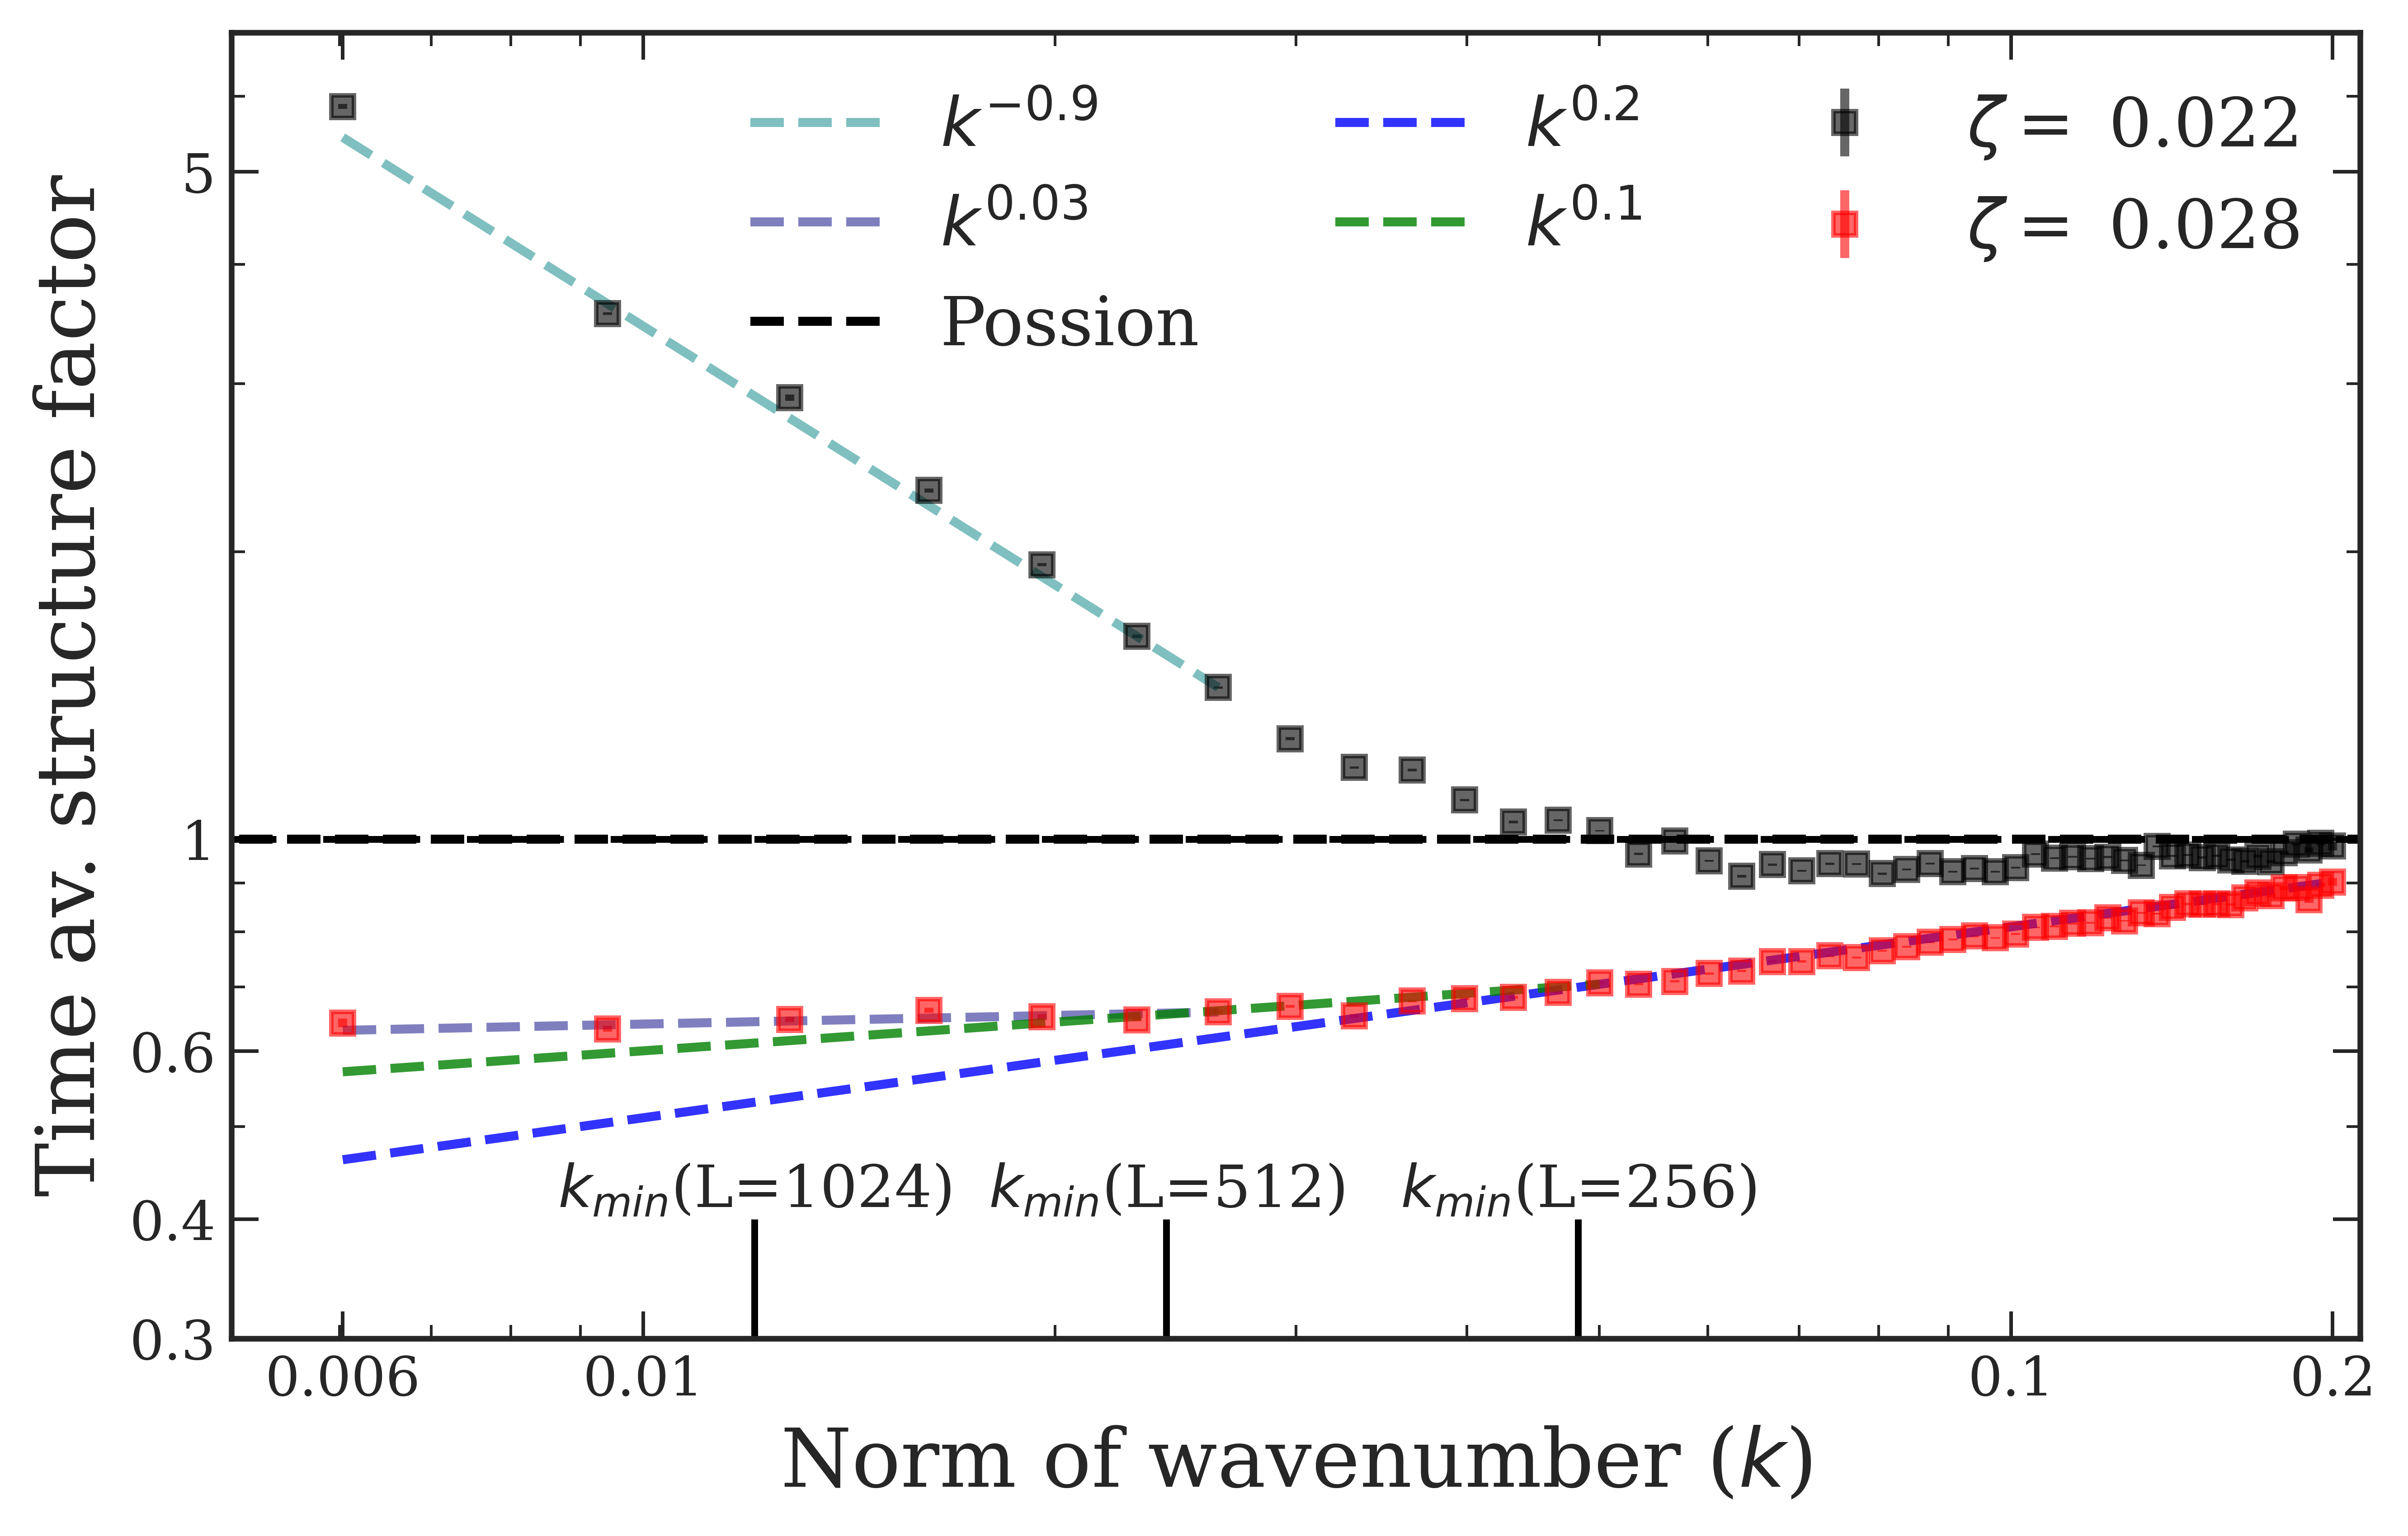

In [138]:
#kmin_list is the smallest k for each L
kmin_list = []
for L in adaa.LX:
    kbins = ada.get_sfac(LX=L,time_av=True)[0]
    kmin_list.append(np.min(kbins))


ratio = 4.5 / 7
w = 7.5
h = w * ratio
fig, ax = plt.subplots(ncols=1,figsize=(w, h))
label_list = [r'$k^{-0.9}$', r'$k^{0.03}$']
scaling_exp_list = [float(label.split('{')[-1].split('}')[0]) for label in label_list]
axx = ada.plot_sfac_per_activity(LX = 2048, Npoints_to_fit=7, act_list=[0.022,0.028,], scaling_exp_list = scaling_exp_list, scaling_label_list=label_list, ax = ax)#act_list = [0.022, 0.024, 0.026, 0.027], weighted = True)
kbins, sfac_av = ada.get_sfac(LX=2048)[:2]

axx.hlines(1, 0, 0.4, color = 'k', linestyle='--', lw=1.5)
axx.set_ylim([0.3, 7])
axx.set_xlim([0.005,0.18])
axx.legend(loc='upper right', ncol=2)
klabel_list = [r'$k_{min}$(L=256)', r'$k_{min}$(L=512)', r'$k_{min}$(L=1024)']
for i, kmin in enumerate(kmin_list[:-1]):
    axx.vlines(kmin, 0.3, .4, color = 'k', linestyle='-', lw=1.5)
    axx.text(kmin, 0.4, klabel_list[i], fontsize=13, verticalalignment='bottom', horizontalalignment='center')
#axx.text(0.7, 0.2, r'L = 1024', transform=axx.transAxes, fontsize=16, verticalalignment='top', fontweight='normal')
#axx.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))

act_idx = ada.act_list[ada.LX.index(2048)].index(0.028)
x = kbins[0:50]
x2 = kbins[0:14]
scaling_exp = .2
scaling_exp2 = .1
axx.plot(x, (sfac_av[-1,act_idx,0]-0.00) * x**scaling_exp / x[-1]**scaling_exp, '--',lw=2, alpha=.8,label=r'$k^{0.2}$', color='blue')
axx.plot(x2, (sfac_av[len(x2),act_idx,0]+0.0) * x2**scaling_exp2 / x2[-1]**scaling_exp2, '--',lw=2, alpha=.8,label=r'$k^{0.1}$', color='green')
axx.legend(ncol=3)
fig.dpi = 720


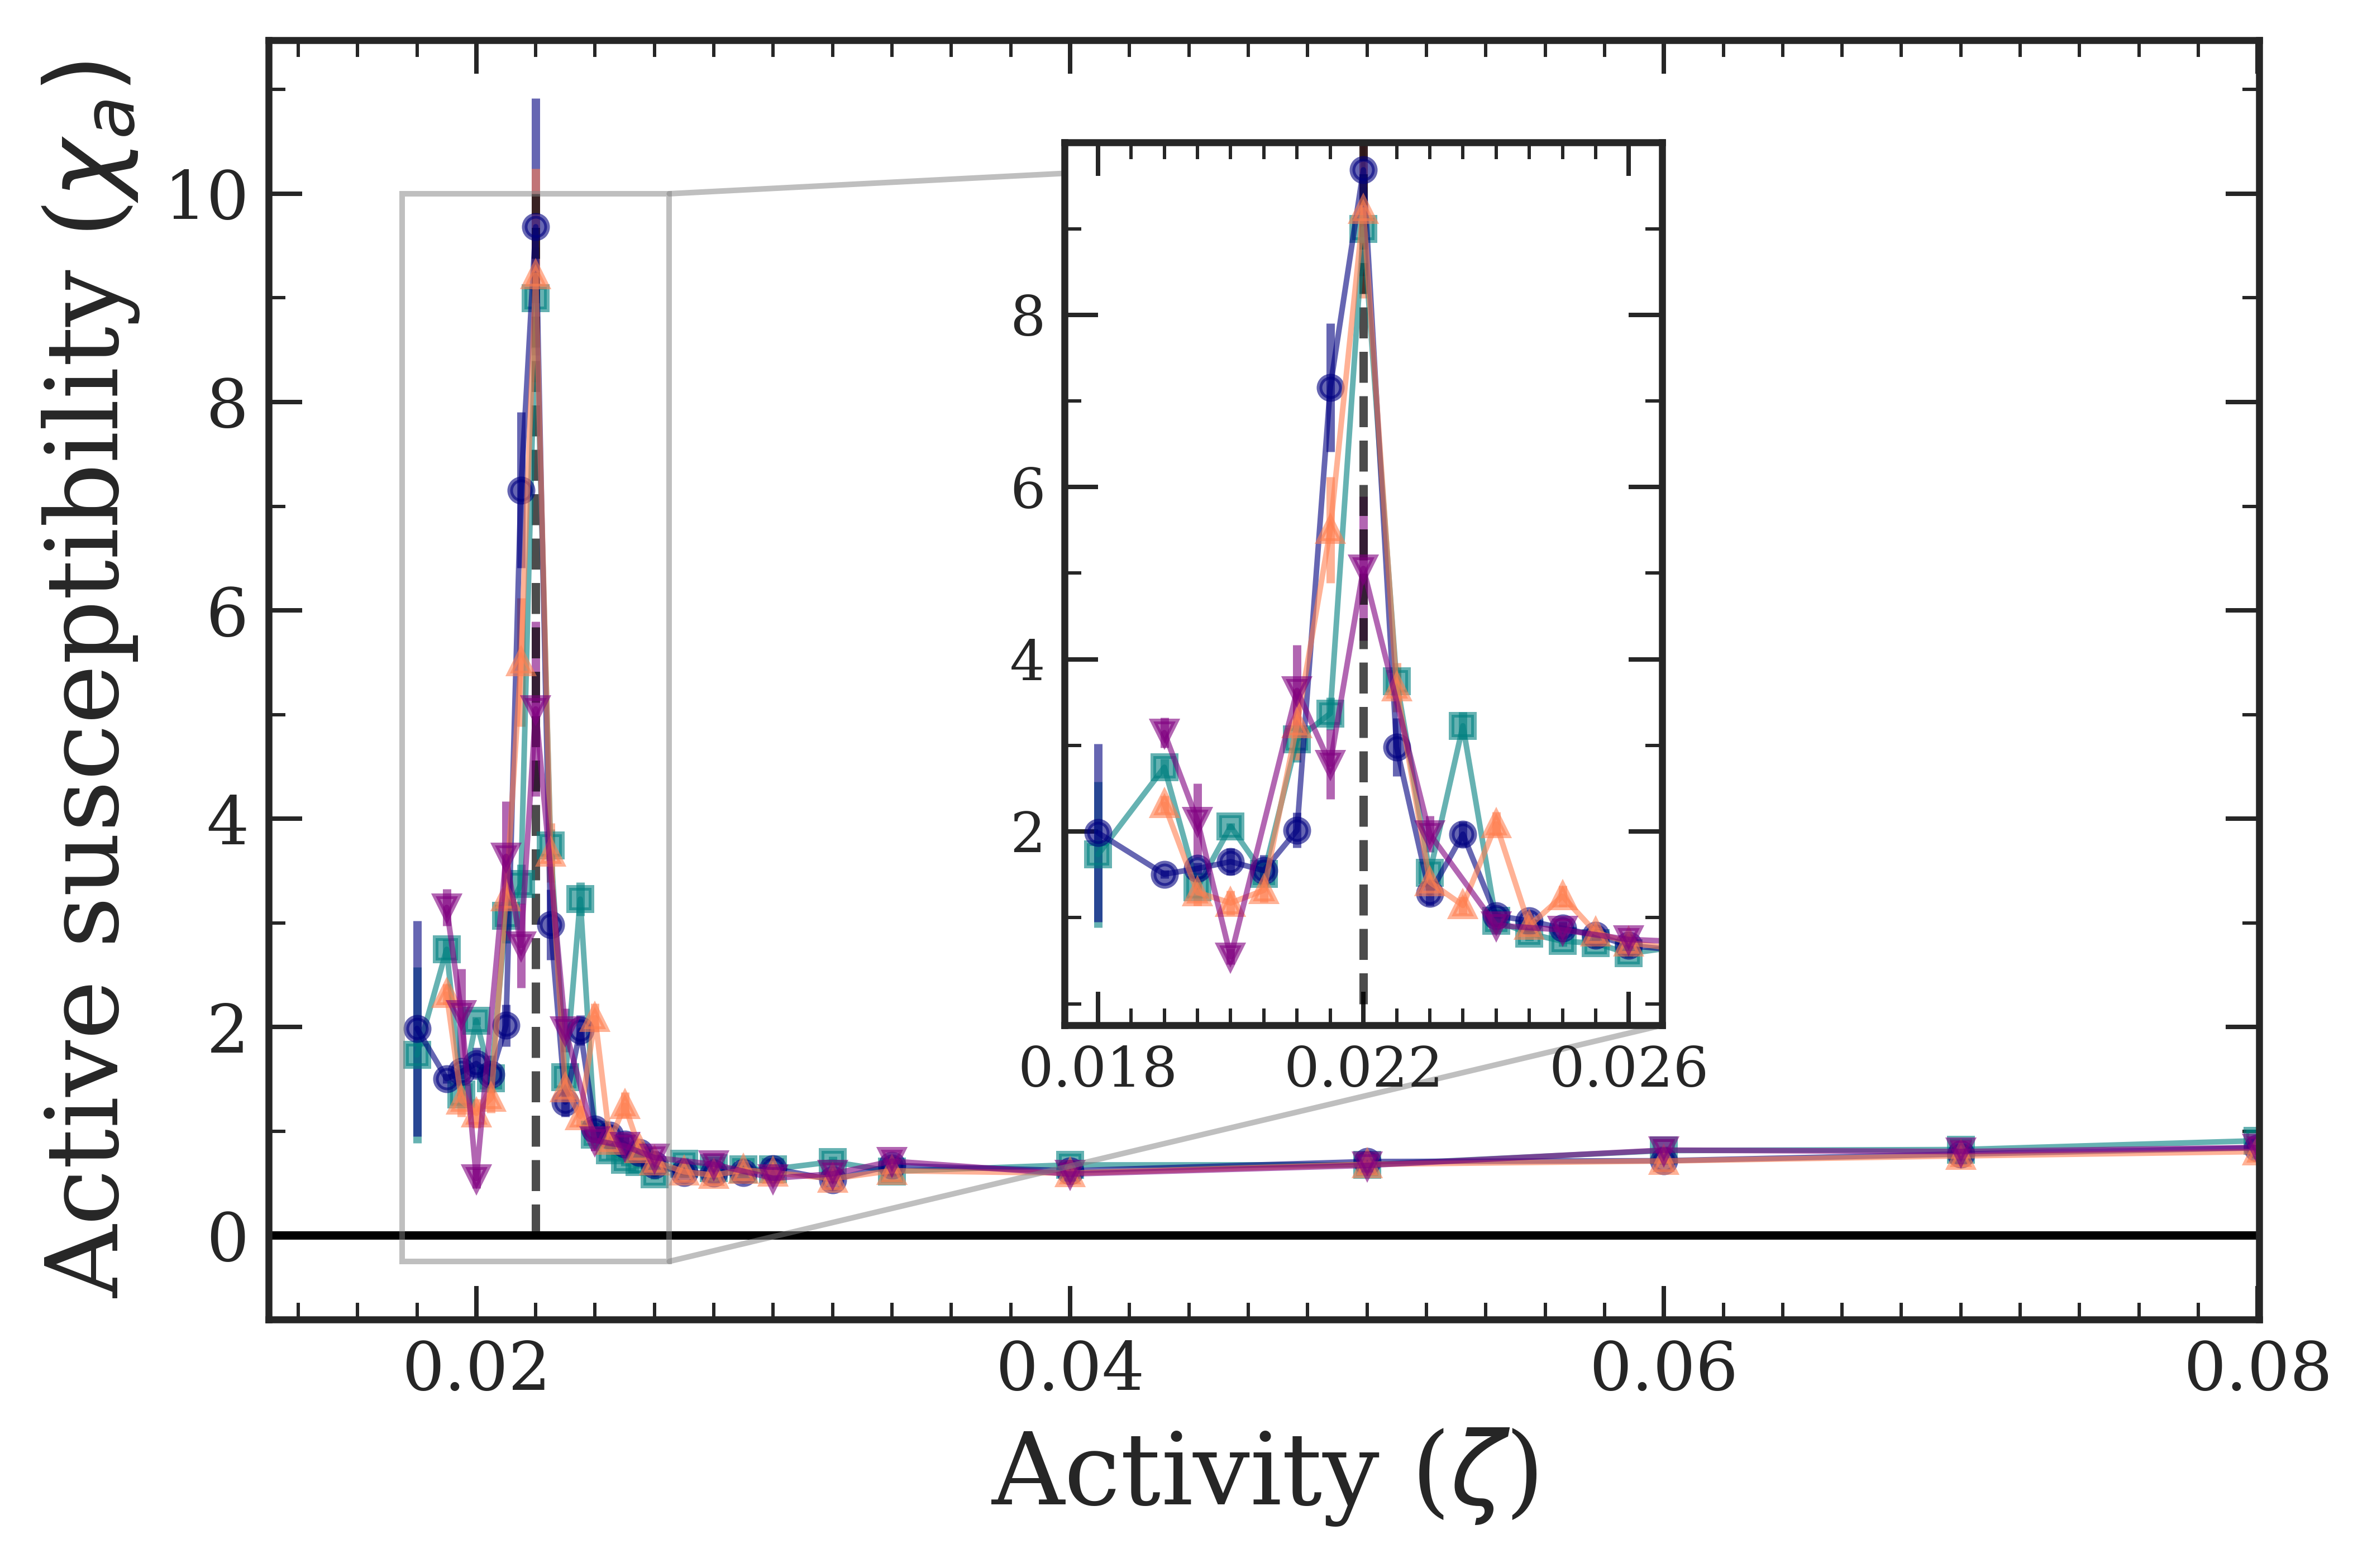

In [24]:
width=6#12*2/5
fig, ax0 = plt.subplots(nrows = 1, ncols = 1, figsize=(width,4.)) 
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

ax = ax0

act_max = 0.022
normalize_sus = False

xmin = 0.37
ymin = 0.08
width = 0.3

inset_box = [0.4, 0.23,width,2.3*width]
axinn = ax.inset_axes(inset_box)

axinn_xlims = [0.0175, 0.0265]
axinn_ylims = [-.25, 10]
axinn_xticks = [1.8e-2, 2.2e-2,2.6e-2]
ax1_xlims = [0.013, 0.08005]
axinn_yticks = np.round(np.linspace(2, 8, 4)).astype('int')
axinn.set(xticks=axinn_xticks, yticks=axinn_yticks, xticklabels=axinn_xticks, yticklabels=axinn_yticks, xlim=axinn_xlims, ylim=axinn_ylims)
ax.indicate_inset_zoom(axinn) 
axinn.tick_params(axis='both',which='major', labelsize=10)


xticks = np.round(np.linspace(0.02, 0.1, 5), 2)
for akse in [ax0]:
    akse.set(xticks=xticks,xticklabels=xticks, xlim=ax1_xlims,)
    akse.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))




for N, act_list in enumerate(ada.act_list):

    sus = ada.get_susceptibility(ada.LX[N])
    act_max_idx = act_list.index(act_max)

    if normalize_sus:    
        sus = sus / sus[act_max_idx].max()

    label = f'L = {ada.LX[N]}'
    ax.errorbar(act_list, sus[:,0],sus[:,1],
                 fmt=f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, label = label, elinewidth=1.5)
    axinn.errorbar(act_list, sus[:,0],sus[:,1], fmt=f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4,elinewidth=1.5)

#ax.set_xlabel(r'Activity ($\zeta$)')
ax.set_ylabel(r'Active susceptibility ($\chi_a)$')
axinn.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw=1.5, alpha=.7, linestyle = '--')
ax.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))

axinn.yaxis.set_minor_locator(ticker.MultipleLocator(1))
axinn.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))

#axinn.legend()
#ax.legend()


ax.hlines(0, 0, 0.1, color = 'k', linestyle='-', lw = 1.5)
ax.set(xlabel = r'Activity ($\zeta$)')
#fig.supxlabel(r'Activity ($\zeta$)',x=0.52, y=0.04)
#fig.legend(ncol=8, fontsize = 16, bbox_to_anchor=(0.88, 1.08))
fig.tight_layout()
fig.dpi = 720
#fig.savefig('data/nematic_analysis_all/susceptibility.eps', dpi = 720, pad_inches = .5)

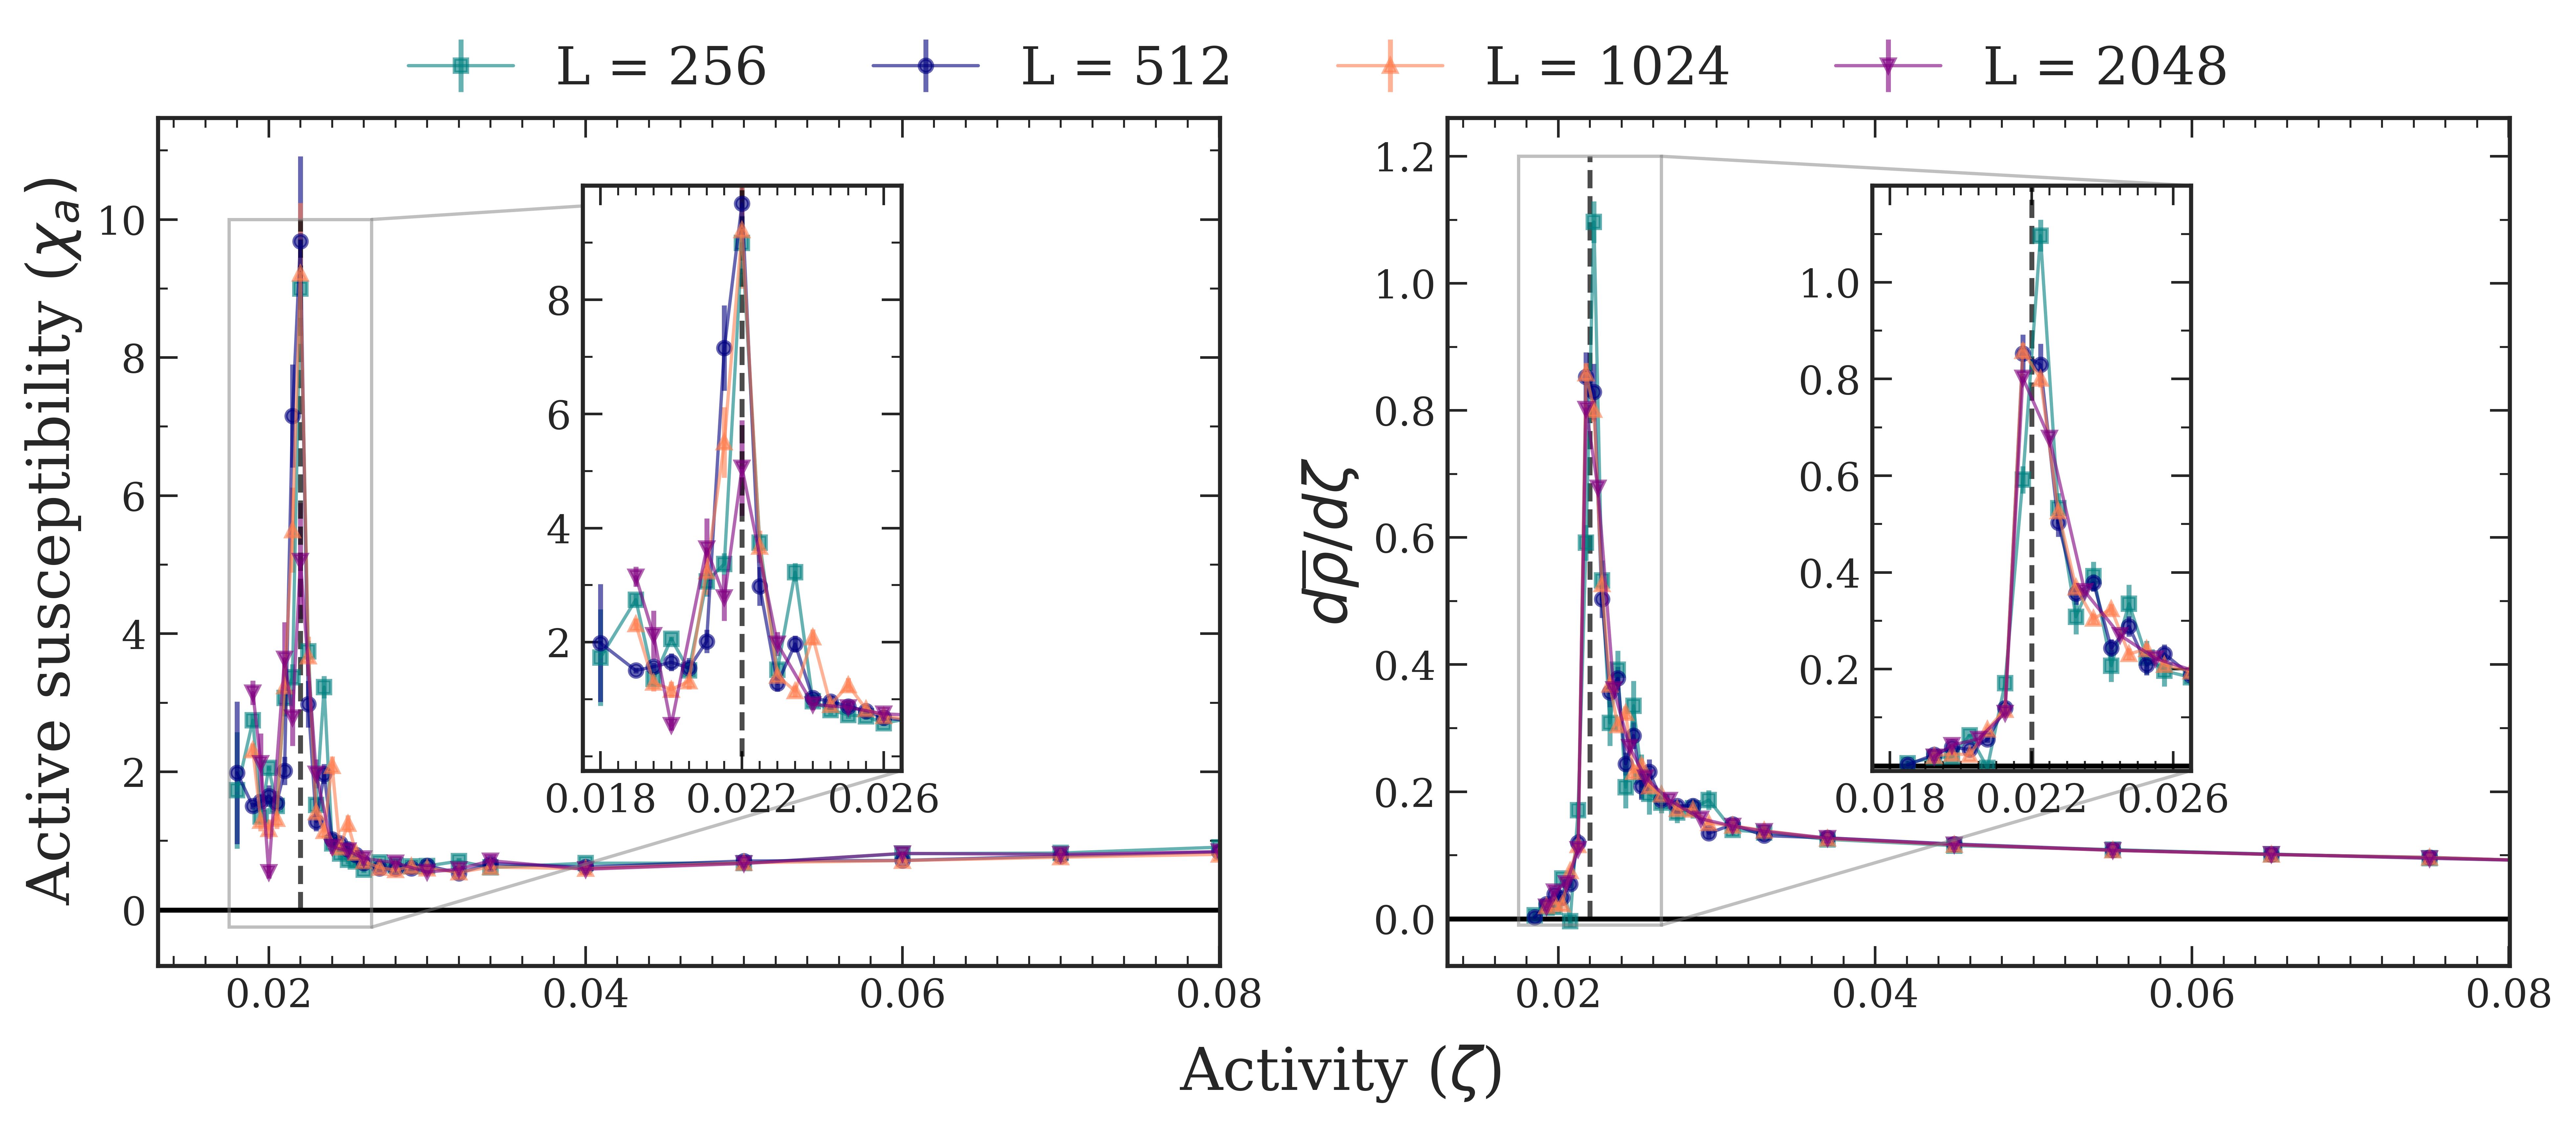

In [5]:

fig, ax0 = plt.subplots(nrows = 1, ncols = 2, figsize=(11,4.5)) 
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
ax0 = ax0.flatten()
ax = ax0[0]
axx = ax0[1]
act_max = 0.022
normalize_sus = False

xmin = 0.37
ymin = 0.08
width = 0.3

inset_box = [0.4, 0.23,width,2.3*width]
axinn = ax.inset_axes(inset_box)
axinn2 = axx.inset_axes(inset_box)

axinn_xlims = [0.0175, 0.0265]
axinn_ylims = [-.25, 10]
axinn2_ylims = [-.01,1.2]
axinn_xticks = [1.8e-2, 2.2e-2,2.6e-2]
ax1_xlims = [0.013, 0.08005]
axinn_yticks = np.round(np.linspace(2, 8, 4)).astype('int')
axinn2_yticks = np.round(np.linspace(0.2,1,5), 1)
axinn.set(xticks=axinn_xticks, yticks=axinn_yticks, xticklabels=axinn_xticks, yticklabels=axinn_yticks, xlim=axinn_xlims, ylim=axinn_ylims)
ax.indicate_inset_zoom(axinn) 

axinn2.set(xticks=axinn_xticks, yticks=axinn2_yticks, xticklabels=axinn_xticks, yticklabels=axinn2_yticks, xlim=axinn_xlims, ylim=axinn2_ylims)
axx.indicate_inset_zoom(axinn2)

xticks = np.round(np.linspace(0.02, 0.1, 5), 2)
for akse in ax0:
    akse.set(xticks=xticks,xticklabels=xticks, xlim=ax1_xlims,)
    akse.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))




for N, act_list in enumerate(ada.act_list):

    sus = ada.get_susceptibility(ada.LX[N])
    act_max_idx = act_list.index(act_max)

    if normalize_sus:    
        sus = sus / sus[act_max_idx].max()

    label = f'L = {ada.LX[N]}'
    ax.errorbar(act_list, sus[:,0],sus[:,1],
                 fmt=f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, label = label, elinewidth=1.5)
    axinn.errorbar(act_list, sus[:,0],sus[:,1], fmt=f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4,elinewidth=1.5)

#ax.set_xlabel(r'Activity ($\zeta$)')
ax.set_ylabel(r'Active susceptibility ($\chi_a)$')
axinn.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw=1.5, alpha=.7, linestyle = '--')
ax.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
axx.vlines(act_max, 0, axinn2_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
axinn2.vlines(act_max, 0, axinn2_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))
axx.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
axinn.yaxis.set_minor_locator(ticker.MultipleLocator(1))
axinn.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))
axinn2.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))
axinn2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
#axinn.legend()
#ax.legend()

marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

act_max = 0.022
for N, act_list in enumerate(ada.act_list):

    sus = ada.get_susceptibility(ada.LX[N])
    av_def = ada.get_av_defects(ada.LX[N])
    av_def_err = av_def[:,1]
    av_def = av_def[:,0]
    act_max_idx = act_list.index(act_max)

    av_def_diff = np.diff(av_def) #/ ada.LX[N]**2    

   # print(len(av_def), len(np.diff(av_def)) )
    act_shift = (np.array(act_list) - act_max) / act_max
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff 
    d_av_def = av_def_diff / act_diff #np.diff(av_def) / np.diff(act_list) #/ ada.LX[N]**2
    err_d_av_def = np.sqrt(av_def_err[1:]**2 + av_def_err[:-1]**2) / act_diff
    label = f'L = {ada.LX[N]}'
    #ax.plot(act_shift, sus[:,0], f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, label = label)
    #axx.plot(act_diff_tot, d_av_def, f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)#, label = label)
    axx.errorbar(np.array(act_list[:-1]) + act_diff/2 , d_av_def, yerr=err_d_av_def, 
                 fmt =  f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, elinewidth=1.5)#, label = label)
    axinn2.errorbar(np.array(act_list[:-1]) + act_diff/2 , d_av_def, 
                    yerr=err_d_av_def, fmt =f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4,elinewidth=1.5)#, label = label)
    #axinn2.plot(act_diff_tot, d_av_def, f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4,)# label = label)

axx.hlines(0, 0, 0.1, color = 'k', linestyle='-', lw=1.5)
ax.hlines(0, 0, 0.1, color = 'k', linestyle='-', lw = 1.5)
axinn2.hlines(0, 0, 0.1, color = 'k', linestyle='-', lw=1.5)    
#axx.set_xlim(ax1_xlims)
#axx.set(xticks=ax)
axx.set_ylabel(r'$d \overline{\rho} / d \zeta$')
fig.supxlabel(r'Activity ($\zeta$)',x=0.52, y=0.04)
fig.legend(ncol=8, fontsize = 16, bbox_to_anchor=(0.88, 1.08))
fig.tight_layout()
fig.dpi = 720
#fig.savefig('data/nematic_analysis_all/susceptibility.eps', dpi = 720, pad_inches = .5)

In [ ]:

fig, ax = plt.subplots(figsize=(7, 4.5)) 

peak1 = 0.022
peak2 = 0.028

xmin = 0.25
ymin = 0.13
width = 0.3
inset_box = [xmin, ymin,1*width,2*width]

plot_fit_of_time_av = True
ax1, axin1 = ada.plot_alpha_mean_sfac(time_av=plot_fit_of_time_av,  ax = ax, inset_box = inset_box)


ax1_xlims = [0.015, 0.105]
ax1_ylims = [-.99, 0.3]
axin1_xlims = [0.0185, 0.0265] #[0.019, 0.035]
axin1_ylims = [ax1_ylims[0], .2] #[-.82, 0.3]


yticks = [-1.25, -1, -.75, -.5, -.25, 0, 0.25, 0.5]
axin1_yticks =  [-1.25, -1, -.75, -.5, -.25, 0, 0.25,]
xticks = np.round(np.linspace(ax1_xlims[0], ax1_xlims[1], 5), 2)
axin1_xticks = np.round(np.linspace(axin1_xlims[0]+0.001, axin1_xlims[1] - 0.001,3), 3)
axin1_xticks = [0.019, 0.022, 0.025]
ax1.set(xticks=xticks, yticks=yticks, xticklabels=xticks, yticklabels=yticks, xlim=ax1_xlims, ylim=ax1_ylims)
axin1.set(xticks=axin1_xticks, yticks=axin1_yticks, xticklabels=axin1_xticks, yticklabels=axin1_yticks, xlim=axin1_xlims, ylim=axin1_ylims)

ax1.vlines(peak1, -2, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
axin1.vlines(peak1, -2, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
#ax1.vlines(peak2, -1, 1, color = 'r', lw = 1.5, linestyle = '--', alpha = 1)
#axin1.vlines(peak2, -1, 1, color = 'r', lw = 1.5, linestyle = '--', alpha = 1)
ax1.hlines(0, 0, 1, color = 'k', lw = 1.5, linestyle = '-', alpha = 1)
axin1.hlines(0, 0, 1, color = 'k', lw = 1.5, linestyle = '-', alpha = 1)
ax1.indicate_inset_zoom(axin1,)
ax1.set_ylabel(r'Scaling exponent ($\hat{\alpha}$)', labelpad=3)

ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))
axin1.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
axin1.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))


ax.legend()
ax1.set_xlabel(r'Activity ($\zeta$)')
fig.tight_layout()
fig.dpi = 720
#fig.savefig('data/hyperuniformity.png', dpi = 420, pad_inches = .5)
#fig.legend(ncol=8, fontsize = 16, bbox_to_anchor=(0.84, 1.025))

#axin1.vlines(peak2, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)

In [68]:
def log_func(x, a, b, c):
    return a * np.log(np.abs(x * b)) + c
def linear(x, a, b):
    return a * x ** 0.5 + b

def power(x, a, b, c):
    return a * x ** b + c
def logistic_func(x, a, b, c, d, e, f):
    val = a / (1 +  np.exp(-b * (x - c))) * ( d * np.log(x) + e * x + f)
    return val
def logistic_func(x, a, b, c):
    val = a / (1 +  np.exp(-b * (x - c))) 
    return val
# do a linear fit to the average defect density



fit_string_logistic = r'$y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} \cdot (d \ln x + ex + f)$'
fit_string_logistic = r'$y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} $'
fit_string_log = rf'$y = a \ln (x / b) + c $'
fit_string_lin = rf'$y = a x + b$'
fit_string_power = rf'$y = a x^b + c$'
param_guess_log = np.array([0.005, 500,0.001])
param_guess_lin = np.array([0.005, 0.04])
param_guess_power = np.array([0.005, 0.5,-0.005])
param_guess_logistic = np.array([0.002, 2000, 0.023,])

fit_func = linear
param_guess = param_guess_lin
fit_string = fit_string_lin

fit_func = logistic_func
param_guess = param_guess_logistic
fit_string = fit_string_logistic

fit_func = power
param_guess = param_guess_power
fit_string = fit_string_power

fit_func = log_func
param_guess = param_guess_log
fit_string = fit_string_log

fit_func = power
param_guess = param_guess_power
fit_string = fit_string_power


fit_dict = dict(fit_func = fit_func, fit_string = fit_string, lower_act_index = 14, param_guess = param_guess)


In [ ]:
fig, ax, axin = ada.plot_av_defects(act_bounds=[0.021, 0.024], inset_box = [0.32, 0.66, 0.25, 0.3])


axin.set_xlim([0.018,0.03])
axin.set_ylim([0.000001, 0.003])
axin.set_xticks([0.02,0.025,0.03], [0.02,0.025,0.03], fontsize=10)
axin.set_yticks([0.001,0.002,0.003], [0.001,0.002,0.003], fontsize=10)

ax.set_xlim([0.01,0.105])
ax.set_ylim([0, 0.012])
ax.vlines(0.022, 0, 0.01, color = 'k', linestyle = '--')
#ax.vlines(0.025, 0, 0.01, color = 'k', linestyle = '--')
#ax.vlines(0.02, 0, 0.01, color = 'k', linestyle = '--')
axin.vlines(0.022, 0, 0.01, color = 'k', lw=1, linestyle = '--')
#axin.vlines(0.02225, 0, 0.01, color = 'g', linestyle = '--', lw=1)


#ax.set_ylim([0, .005])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log')
ax.legend(ncol=2, loc='lower right')

ax.indicate_inset_zoom(axin)
fig.dpi=720
fig.savefig('test.png', dpi = 720, pad_inches = .5)

NameError: name 'logistic_func' is not defined

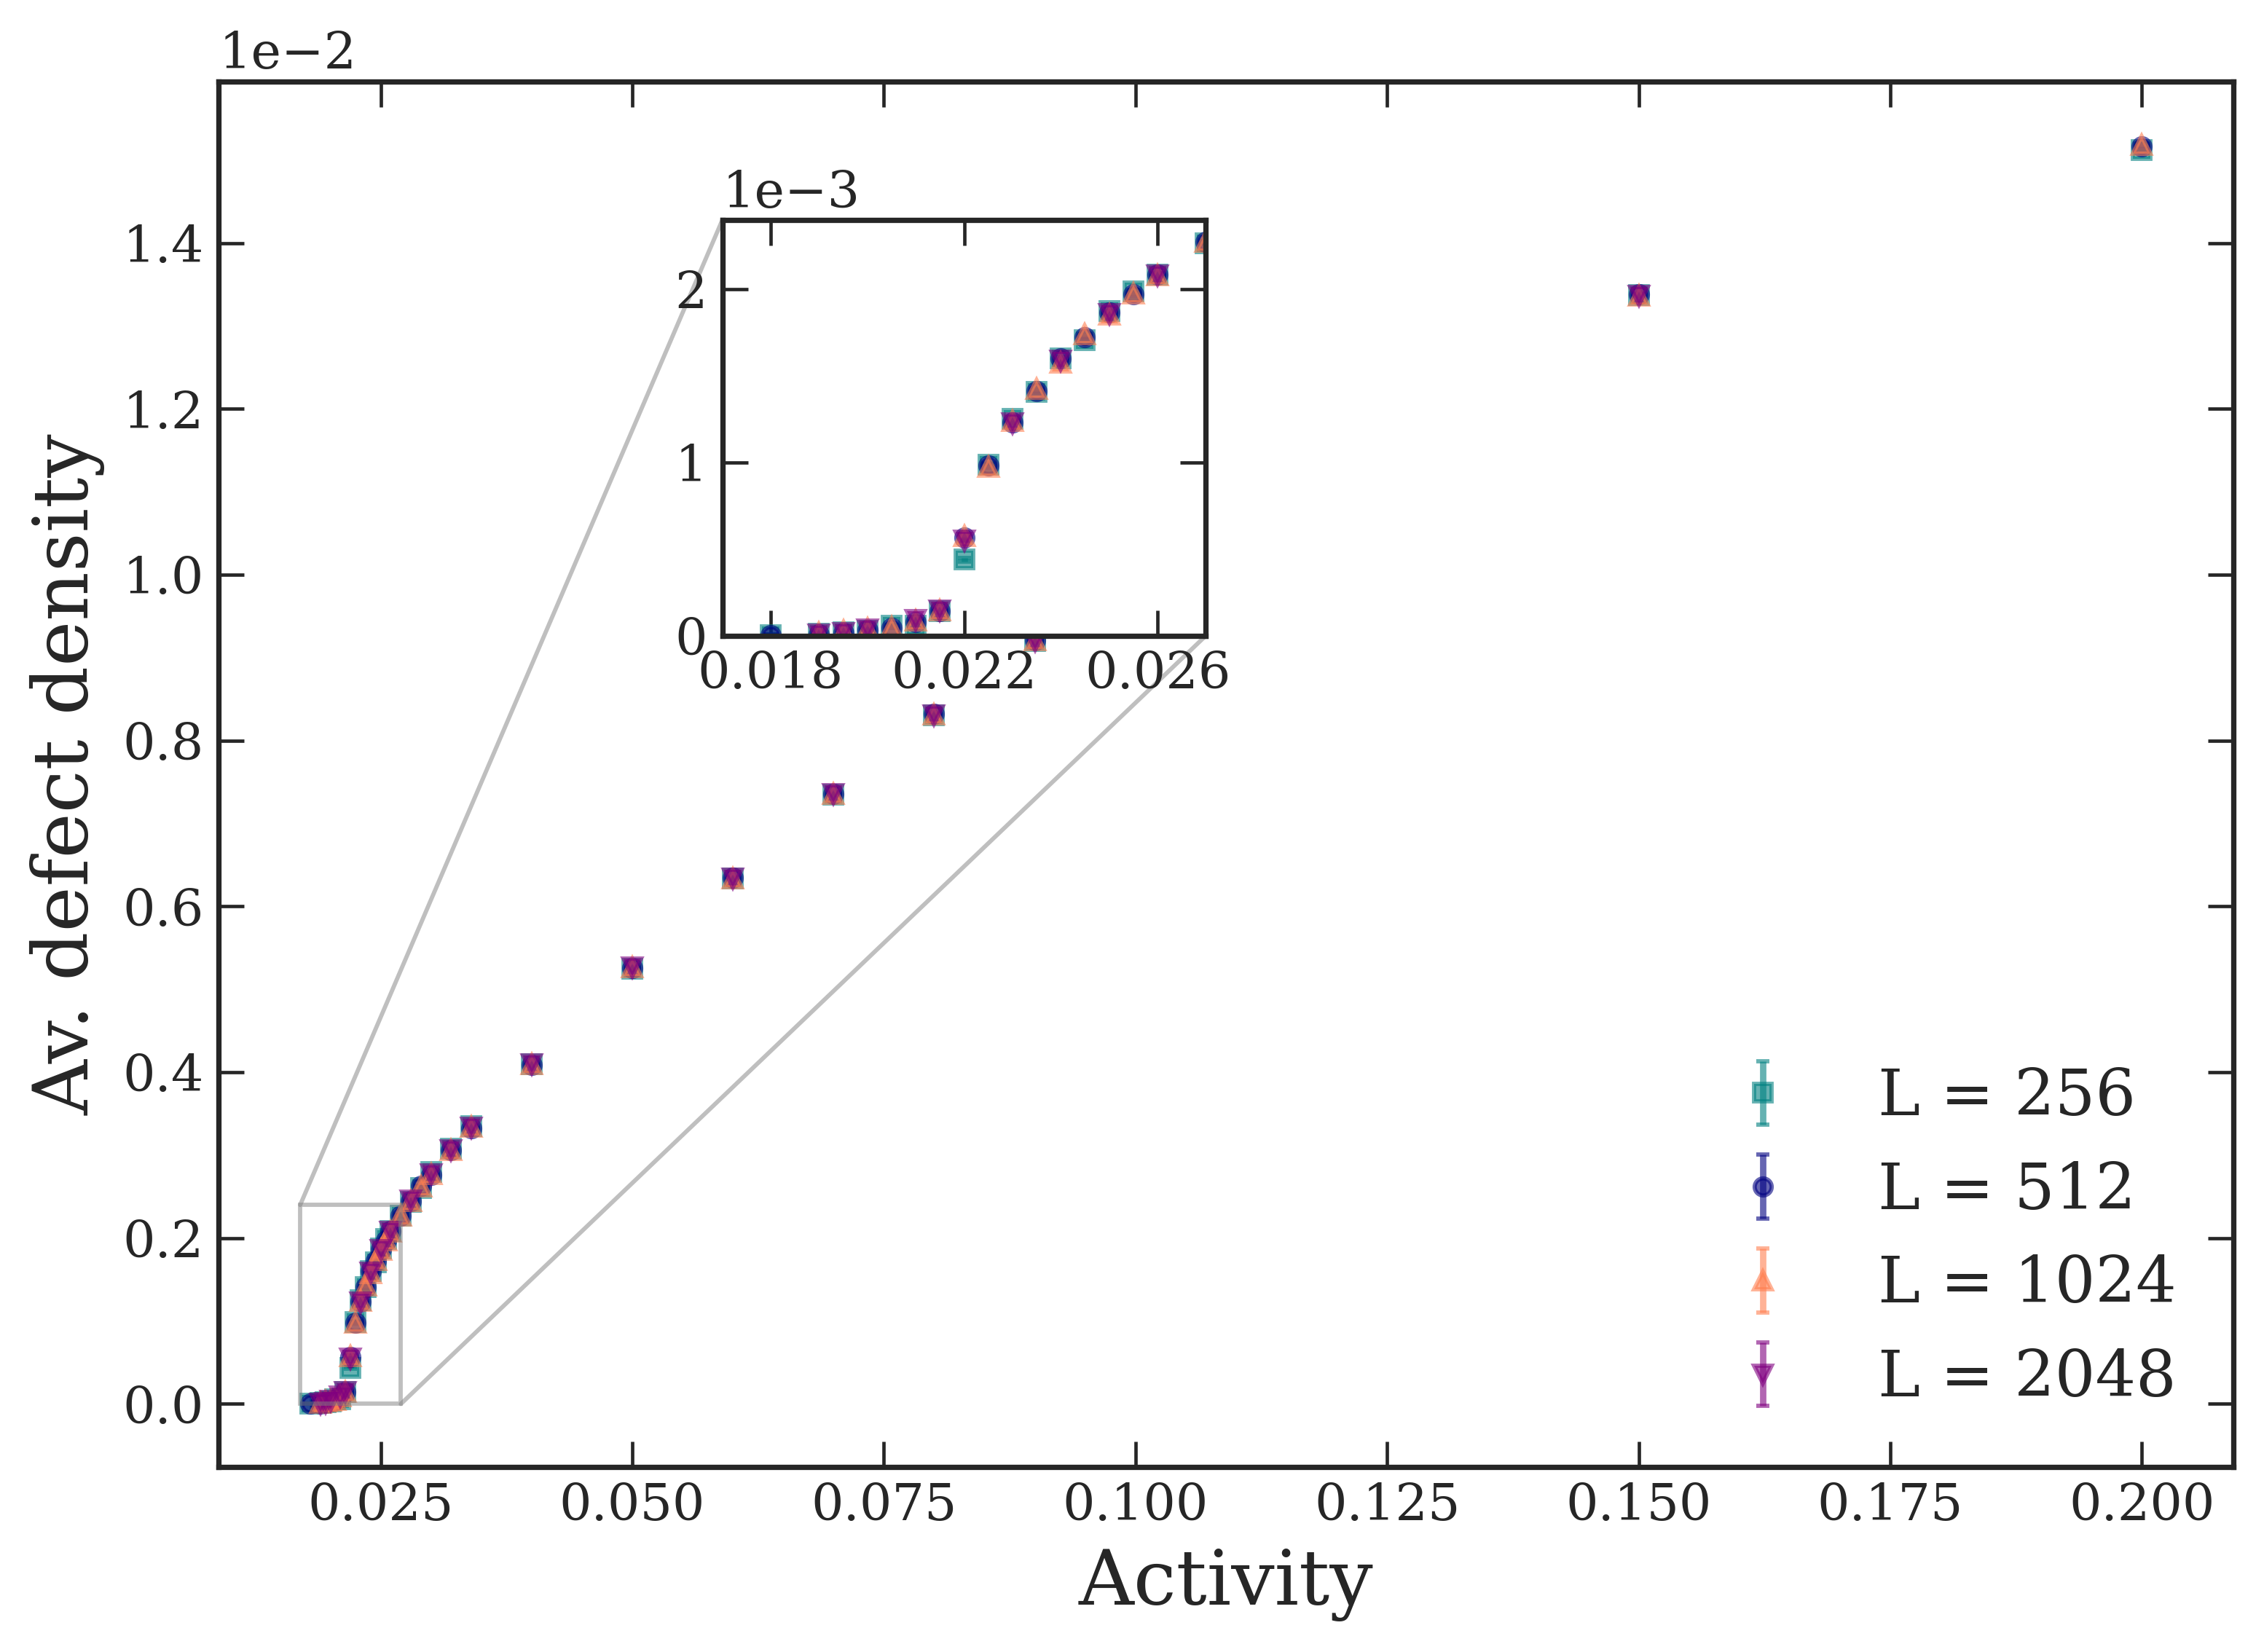

In [4]:


width = .3
inset_box = [0.25, 0.6,.8*width,1*width]

fig, ax, axin = ada.plot_av_defects(figsize=(7.5,5.5),act_bounds=[0.021, 0.024], inset_box =inset_box)#= [0.32, 0.66, 0.25, 0.3])

p_power = np.array([0.05563591932395208, 0.5925762989386102, -0.004164450175068781])
p_log = np.array([0.004958101922293866, 55.446575064673716, 0.00026152453890848973])
p_logistic = np.array([0.001622290610085664, 2324.4665041694207, 0.022408143634890017])
p_logistic = np.array([0.0017626217917815334, 1822.8633695130754, 0.02257778086582252])

#axin = ax.inset_axes([0.3, 0.64, 0.2, 0.25])
axin.set_xlim([0.017,0.027])
axin.set_ylim([0.000, 0.0024])
axin.set_xticks([0.018,0.022,0.026], [0.018,0.022,0.026])
#axin.set_yticks([5e-3, 1e-3, 1.5e-3,2e-3,2.5e-3], [5e-4, 1e-4, 1.5e-4,2e-4,2.5e-4])

ax.indicate_inset_zoom(axin)

act_list = ada.act_list[0]
act_list_power = act_list[act_list.index(0.025):]
act_list_log = np.array(act_list[act_list.index(0.025):act_list.index(0.032)])
act_list_logistic = np.array(act_list[act_list.index(0.02):act_list.index(0.025)])


fit_string_logistic = r'$y_2 = \frac{{a_2}}{{1 + e^{{-b_2(x-c_2)}}}} $'
fit_string_log = rf'$y_2 = a \ln (x / b) + c $'
fit_string_power = r'$y_1 = a_1 x^{b_1} + c_1$'

fit_string_logistic = r'$y_2$ = Logistic fit'
fit_string_power = r'$y_1 \sim \zeta^{0.6}$'

fits = []
fits += ax.plot(act_list_logistic, logistic_func(act_list_logistic, *p_logistic), '-', color=f'C7')

fits += ax.plot(act_list_power, power(act_list_power, *p_power), '-', color=f'C5')
#ax.plot(act_list_log, log_func(act_list_log, *p_log), '-', label = fit_string_log, color=f'C6')

axin.plot(act_list_power, power(act_list_power, *p_power), '-', label = fit_string_power, color=f'C5')
#axin.plot(act_list_log, log_func(act_list_log, *p_log), '-', label = fit_string_log, color=f'C6', lw=3)
axin.plot(act_list_logistic, logistic_func(act_list_logistic, *p_logistic), '-', label = fit_string_logistic, color=f'C7')



ax.set_xlim([0.01,0.105])
ax.set_ylim([0, 0.012])
#ax.vlines(0.03, 0, 0.01, color = 'k', linestyle = '--')
#ax.vlines(0.025, 0, 0.02, color = 'k',lw=1.5, linestyle = '--')
ax.vlines(0.022, 0, 0.02, color = 'k',lw=1.5, linestyle = '--')
axin.vlines(0.022, 0, 0.01, color = 'k', lw=1.5, linestyle = '--')
#axin.vlines(0.025, 0, 0.01, color = 'k',lw=1.5, linestyle = '--')
#axin.vlines(0.02225, 0, 0.01, color = 'g', linestyle = '--', lw=1)

ax.xaxis.set_minor_locator(ticker.MultipleLocator(5e-3))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1e-3))
axin.yaxis.set_minor_locator(ticker.MultipleLocator(5e-4))
axin.xaxis.set_minor_locator(ticker.MultipleLocator(1e-3))
#ax.set_ylim([0, .005])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log')
ax.axvspan(0, 0.02, facecolor='teal', alpha=0.2)#, label = 'd')
ax.axvspan(0.02, 0.025, facecolor='g', alpha=0.2)
ax.axvspan(0.025, 0.14, facecolor='grey', alpha=0.2)
axin.axvspan(0, 0.02, facecolor='teal', alpha=0.2, label = 'D')
axin.axvspan(0.02, 0.025, facecolor='g', alpha=0.2)
axin.axvspan(0.025, 0.14, facecolor='grey', alpha=0.2)

#fig.legend(ncol=2, loc='upper center')
ax.legend(ncol=2, loc='lower right')#, bbox_to_anchor=(.5, 0.9))
leg = Legend(ax, fits[:], [fit_string_logistic, fit_string_power],
             loc='upper right', frameon=False, bbox_to_anchor=(0.95, 0.96))
ax.add_artist(leg);
p_power